# Getting started

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dropout

In [45]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [46]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


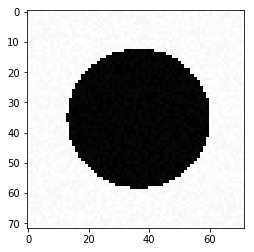

In [47]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [48]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [50]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple Classification

#### Generate set of images 

In [51]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


#### Checking the classifiers

In [8]:
def test_classifiers(type_of_figure, nb_sample, noise=0.0):
    X_test = np.empty((1,len(X_train[1])))
    if type_of_figure == 'rectangle': 
        for i in range(nb_sample):
            test = generate_a_rectangle(noise)
            X_test = np.append(X_test,
                               test.reshape(1, test.shape[0]),
                               axis=0)
    elif type_of_figure == 'disk':
        for i in range(nb_sample):
            test = generate_a_disk(noise)
            X_test = np.append(X_test,
                               test.reshape(1, test.shape[0]),
                               axis=0)
    elif type_of_figure == 'triangle':
        for i in range(nb_sample):
            test = generate_a_triangle(noise)
            X_test = np.append(X_test,
                               test.reshape(1, test.shape[0]),
                               axis=0)
    
    return np.delete(X_test, (0), axis=0)

In [10]:

X_test_disk = test_classifiers('disk', 300)


In [11]:
X_test_disk.shape


(300, 5184)

In [52]:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping # for stopping befor n_epochs if performance doesn't increase
from keras.optimizers import SGD

In [53]:
input_shape = X_train.shape[1]  
target = to_categorical(Y_train)

In [54]:
def get_new_model(number_nodes_per_layer):
    model = Sequential()
    model.add(Dense(number_nodes_per_layer, activation='relu', input_shape=(input_shape,)))
    #model.add(Dense(nb_node_per_layer, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    return model

In [55]:
lr_to_test = [0.0001,0.001,0.01] #looping over learning rates
number_nodes_per_layer=[100,250,350]

In [35]:
early_stopping_monitor = EarlyStopping(patience=3)

# Double loop over learning rates and 
for nb_nodes in number_nodes_per_layer:
    for lr in lr_to_test: 
        print("----- Learning rate = ", lr,"\n")

        model = get_new_model(number_nodes_per_layer= nb_nodes)

        my_optimizer=SGD(lr=lr)

        model.compile(optimizer=my_optimizer, 
                      loss = 'categorical_crossentropy',
                      metrics=['accuracy'],
                     )

        model.fit(X_train, 
                  target, 
                  validation_split=0.3,
                  epochs = 1500, 
                  #callbacks=[early_stopping_monitor]
                 )

        print("\t\t Learning rate = ", lr, "number_nodes = ", nb_nodes, " model summary\n")
        model.summary()

        predictions = model.predict(X_train)

----- Learning rate =  0.0001 

Train on 210 samples, validate on 90 samples
Epoch 1/1500
210/210 [==============================] - 1s 7ms/step - loss: 1.1648 - acc: 0.3905 - val_loss: 1.2998 - val_acc: 0.2667
Epoch 2/1500
210/210 [==============================] - 0s 359us/step - loss: 1.0324 - acc: 0.4333 - val_loss: 1.1534 - val_acc: 0.4000
Epoch 3/1500
210/210 [==============================] - 0s 339us/step - loss: 0.9832 - acc: 0.5048 - val_loss: 1.1069 - val_acc: 0.4444
Epoch 4/1500
210/210 [==============================] - 0s 411us/step - loss: 0.9596 - acc: 0.5238 - val_loss: 1.0751 - val_acc: 0.4556
Epoch 5/1500
210/210 [==============================] - 0s 445us/step - loss: 0.9425 - acc: 0.5524 - val_loss: 1.0561 - val_acc: 0.4556
Epoch 6/1500
210/210 [==============================] - 0s 431us/step - loss: 0.9280 - acc: 0.5571 - val_loss: 1.0346 - val_acc: 0.4556
Epoch 7/1500
210/210 [==============================] - 0s 444us/step - loss: 0.9135 - acc: 0.5905 - val_loss

Epoch 120/1500
210/210 [==============================] - 0s 337us/step - loss: 0.5241 - acc: 0.8429 - val_loss: 0.6869 - val_acc: 0.6444
Epoch 121/1500
210/210 [==============================] - 0s 412us/step - loss: 0.5220 - acc: 0.8667 - val_loss: 0.6845 - val_acc: 0.6556
Epoch 122/1500
210/210 [==============================] - 0s 359us/step - loss: 0.5211 - acc: 0.8714 - val_loss: 0.6848 - val_acc: 0.6556
Epoch 123/1500
210/210 [==============================] - 0s 403us/step - loss: 0.5187 - acc: 0.8714 - val_loss: 0.6828 - val_acc: 0.6667
Epoch 124/1500
210/210 [==============================] - 0s 411us/step - loss: 0.5179 - acc: 0.8714 - val_loss: 0.6828 - val_acc: 0.6556
Epoch 125/1500
210/210 [==============================] - 0s 347us/step - loss: 0.5160 - acc: 0.8810 - val_loss: 0.6850 - val_acc: 0.6333
Epoch 126/1500
210/210 [==============================] - 0s 390us/step - loss: 0.5154 - acc: 0.8762 - val_loss: 0.6857 - val_acc: 0.6556
Epoch 127/1500
210/210 [==========

210/210 [==============================] - 0s 378us/step - loss: 0.3896 - acc: 0.9429 - val_loss: 0.5600 - val_acc: 0.8222
Epoch 239/1500
210/210 [==============================] - 0s 399us/step - loss: 0.3892 - acc: 0.9429 - val_loss: 0.5621 - val_acc: 0.7889
Epoch 240/1500
210/210 [==============================] - 0s 437us/step - loss: 0.3889 - acc: 0.9381 - val_loss: 0.5622 - val_acc: 0.7667
Epoch 241/1500
210/210 [==============================] - 0s 427us/step - loss: 0.3886 - acc: 0.9429 - val_loss: 0.5630 - val_acc: 0.7556
Epoch 242/1500
210/210 [==============================] - 0s 422us/step - loss: 0.3871 - acc: 0.9381 - val_loss: 0.5587 - val_acc: 0.7889
Epoch 243/1500
210/210 [==============================] - 0s 432us/step - loss: 0.3860 - acc: 0.9429 - val_loss: 0.5581 - val_acc: 0.7889
Epoch 244/1500
210/210 [==============================] - 0s 487us/step - loss: 0.3855 - acc: 0.9381 - val_loss: 0.5541 - val_acc: 0.8333
Epoch 245/1500
210/210 [=========================

210/210 [==============================] - 0s 338us/step - loss: 0.3187 - acc: 0.9667 - val_loss: 0.4822 - val_acc: 0.9111
Epoch 357/1500
210/210 [==============================] - 0s 413us/step - loss: 0.3182 - acc: 0.9762 - val_loss: 0.4847 - val_acc: 0.8889
Epoch 358/1500
210/210 [==============================] - 0s 412us/step - loss: 0.3188 - acc: 0.9619 - val_loss: 0.4803 - val_acc: 0.9111
Epoch 359/1500
210/210 [==============================] - 0s 426us/step - loss: 0.3175 - acc: 0.9714 - val_loss: 0.4792 - val_acc: 0.9000
Epoch 360/1500
210/210 [==============================] - 0s 427us/step - loss: 0.3176 - acc: 0.9762 - val_loss: 0.4802 - val_acc: 0.9111
Epoch 361/1500
210/210 [==============================] - 0s 398us/step - loss: 0.3162 - acc: 0.9667 - val_loss: 0.4805 - val_acc: 0.9111
Epoch 362/1500
210/210 [==============================] - 0s 434us/step - loss: 0.3153 - acc: 0.9714 - val_loss: 0.4808 - val_acc: 0.9111
Epoch 363/1500
210/210 [=========================

210/210 [==============================] - 0s 377us/step - loss: 0.2709 - acc: 0.9762 - val_loss: 0.4256 - val_acc: 0.9111
Epoch 475/1500
210/210 [==============================] - 0s 423us/step - loss: 0.2707 - acc: 0.9810 - val_loss: 0.4259 - val_acc: 0.9111
Epoch 476/1500
210/210 [==============================] - 0s 422us/step - loss: 0.2707 - acc: 0.9810 - val_loss: 0.4247 - val_acc: 0.9111
Epoch 477/1500
210/210 [==============================] - 0s 479us/step - loss: 0.2703 - acc: 0.9810 - val_loss: 0.4241 - val_acc: 0.9111
Epoch 478/1500
210/210 [==============================] - 0s 429us/step - loss: 0.2702 - acc: 0.9857 - val_loss: 0.4221 - val_acc: 0.9111
Epoch 479/1500
210/210 [==============================] - 0s 406us/step - loss: 0.2692 - acc: 0.9810 - val_loss: 0.4218 - val_acc: 0.9111
Epoch 480/1500
210/210 [==============================] - 0s 443us/step - loss: 0.2702 - acc: 0.9810 - val_loss: 0.4233 - val_acc: 0.9111
Epoch 481/1500
210/210 [=========================

210/210 [==============================] - 0s 412us/step - loss: 0.2368 - acc: 0.9905 - val_loss: 0.3851 - val_acc: 0.9111
Epoch 593/1500
210/210 [==============================] - 0s 317us/step - loss: 0.2362 - acc: 0.9905 - val_loss: 0.3845 - val_acc: 0.9111
Epoch 594/1500
210/210 [==============================] - 0s 310us/step - loss: 0.2363 - acc: 0.9905 - val_loss: 0.3847 - val_acc: 0.9111
Epoch 595/1500
210/210 [==============================] - 0s 335us/step - loss: 0.2363 - acc: 0.9905 - val_loss: 0.3840 - val_acc: 0.9111
Epoch 596/1500
210/210 [==============================] - 0s 336us/step - loss: 0.2356 - acc: 0.9905 - val_loss: 0.3837 - val_acc: 0.9111
Epoch 597/1500
210/210 [==============================] - 0s 366us/step - loss: 0.2358 - acc: 0.9905 - val_loss: 0.3822 - val_acc: 0.9111
Epoch 598/1500
210/210 [==============================] - 0s 385us/step - loss: 0.2352 - acc: 0.9905 - val_loss: 0.3834 - val_acc: 0.9111
Epoch 599/1500
210/210 [=========================

210/210 [==============================] - 0s 411us/step - loss: 0.2100 - acc: 0.9905 - val_loss: 0.3523 - val_acc: 0.9111
Epoch 711/1500
210/210 [==============================] - 0s 332us/step - loss: 0.2101 - acc: 0.9905 - val_loss: 0.3526 - val_acc: 0.9111
Epoch 712/1500
210/210 [==============================] - 0s 333us/step - loss: 0.2101 - acc: 0.9905 - val_loss: 0.3517 - val_acc: 0.9111
Epoch 713/1500
210/210 [==============================] - 0s 321us/step - loss: 0.2097 - acc: 0.9905 - val_loss: 0.3517 - val_acc: 0.9111
Epoch 714/1500
210/210 [==============================] - 0s 335us/step - loss: 0.2097 - acc: 0.9905 - val_loss: 0.3504 - val_acc: 0.9111
Epoch 715/1500
210/210 [==============================] - 0s 312us/step - loss: 0.2101 - acc: 0.9905 - val_loss: 0.3490 - val_acc: 0.9111
Epoch 716/1500
210/210 [==============================] - 0s 325us/step - loss: 0.2100 - acc: 0.9905 - val_loss: 0.3496 - val_acc: 0.9111
Epoch 717/1500
210/210 [=========================

210/210 [==============================] - 0s 397us/step - loss: 0.1892 - acc: 0.9905 - val_loss: 0.3237 - val_acc: 0.9222
Epoch 829/1500
210/210 [==============================] - 0s 352us/step - loss: 0.1891 - acc: 0.9905 - val_loss: 0.3233 - val_acc: 0.9222
Epoch 830/1500
210/210 [==============================] - 0s 431us/step - loss: 0.1889 - acc: 0.9905 - val_loss: 0.3234 - val_acc: 0.9222
Epoch 831/1500
210/210 [==============================] - 0s 348us/step - loss: 0.1891 - acc: 0.9905 - val_loss: 0.3229 - val_acc: 0.9222
Epoch 832/1500
210/210 [==============================] - 0s 424us/step - loss: 0.1891 - acc: 0.9905 - val_loss: 0.3242 - val_acc: 0.9222
Epoch 833/1500
210/210 [==============================] - 0s 386us/step - loss: 0.1889 - acc: 0.9905 - val_loss: 0.3238 - val_acc: 0.9222
Epoch 834/1500
210/210 [==============================] - 0s 443us/step - loss: 0.1882 - acc: 0.9905 - val_loss: 0.3237 - val_acc: 0.9222
Epoch 835/1500
210/210 [=========================

210/210 [==============================] - 0s 350us/step - loss: 0.1721 - acc: 0.9905 - val_loss: 0.3018 - val_acc: 0.9222
Epoch 947/1500
210/210 [==============================] - 0s 441us/step - loss: 0.1716 - acc: 0.9905 - val_loss: 0.3019 - val_acc: 0.9222
Epoch 948/1500
210/210 [==============================] - 0s 433us/step - loss: 0.1719 - acc: 0.9905 - val_loss: 0.3010 - val_acc: 0.9222
Epoch 949/1500
210/210 [==============================] - 0s 442us/step - loss: 0.1713 - acc: 0.9905 - val_loss: 0.3020 - val_acc: 0.9222
Epoch 950/1500
210/210 [==============================] - 0s 431us/step - loss: 0.1715 - acc: 0.9905 - val_loss: 0.3010 - val_acc: 0.9222
Epoch 951/1500
210/210 [==============================] - 0s 428us/step - loss: 0.1710 - acc: 0.9905 - val_loss: 0.3012 - val_acc: 0.9222
Epoch 952/1500
210/210 [==============================] - 0s 361us/step - loss: 0.1716 - acc: 0.9905 - val_loss: 0.3013 - val_acc: 0.9222
Epoch 953/1500
210/210 [=========================

210/210 [==============================] - 0s 462us/step - loss: 0.1574 - acc: 0.9905 - val_loss: 0.2815 - val_acc: 0.9333
Epoch 1065/1500
210/210 [==============================] - 0s 367us/step - loss: 0.1572 - acc: 0.9905 - val_loss: 0.2818 - val_acc: 0.9333
Epoch 1066/1500
210/210 [==============================] - 0s 293us/step - loss: 0.1573 - acc: 0.9905 - val_loss: 0.2817 - val_acc: 0.9333
Epoch 1067/1500
210/210 [==============================] - 0s 317us/step - loss: 0.1572 - acc: 0.9905 - val_loss: 0.2815 - val_acc: 0.9333
Epoch 1068/1500
210/210 [==============================] - 0s 392us/step - loss: 0.1572 - acc: 0.9905 - val_loss: 0.2817 - val_acc: 0.9333
Epoch 1069/1500
210/210 [==============================] - 0s 334us/step - loss: 0.1574 - acc: 0.9905 - val_loss: 0.2818 - val_acc: 0.9333
Epoch 1070/1500
210/210 [==============================] - 0s 401us/step - loss: 0.1570 - acc: 0.9905 - val_loss: 0.2816 - val_acc: 0.9333
Epoch 1071/1500
210/210 [==================

210/210 [==============================] - 0s 405us/step - loss: 0.1511 - acc: 0.9905 - val_loss: 0.2736 - val_acc: 0.9333
Epoch 1124/1500
210/210 [==============================] - 0s 402us/step - loss: 0.1509 - acc: 0.9905 - val_loss: 0.2735 - val_acc: 0.9333
Epoch 1125/1500
210/210 [==============================] - 0s 434us/step - loss: 0.1510 - acc: 0.9905 - val_loss: 0.2732 - val_acc: 0.9333
Epoch 1126/1500
210/210 [==============================] - 0s 419us/step - loss: 0.1507 - acc: 0.9905 - val_loss: 0.2728 - val_acc: 0.9333
Epoch 1127/1500
210/210 [==============================] - 0s 387us/step - loss: 0.1507 - acc: 0.9905 - val_loss: 0.2723 - val_acc: 0.9333
Epoch 1128/1500
210/210 [==============================] - 0s 340us/step - loss: 0.1504 - acc: 0.9905 - val_loss: 0.2719 - val_acc: 0.9333
Epoch 1129/1500
210/210 [==============================] - 0s 386us/step - loss: 0.1503 - acc: 0.9905 - val_loss: 0.2722 - val_acc: 0.9333
Epoch 1130/1500
210/210 [==================

210/210 [==============================] - 0s 408us/step - loss: 0.1455 - acc: 0.9905 - val_loss: 0.2641 - val_acc: 0.9333
Epoch 1183/1500
210/210 [==============================] - 0s 372us/step - loss: 0.1451 - acc: 0.9905 - val_loss: 0.2641 - val_acc: 0.9333
Epoch 1184/1500
210/210 [==============================] - 0s 427us/step - loss: 0.1449 - acc: 0.9905 - val_loss: 0.2638 - val_acc: 0.9333
Epoch 1185/1500
210/210 [==============================] - 0s 425us/step - loss: 0.1449 - acc: 0.9905 - val_loss: 0.2640 - val_acc: 0.9333
Epoch 1186/1500
210/210 [==============================] - 0s 420us/step - loss: 0.1447 - acc: 0.9905 - val_loss: 0.2641 - val_acc: 0.9333
Epoch 1187/1500
210/210 [==============================] - 0s 430us/step - loss: 0.1450 - acc: 0.9905 - val_loss: 0.2641 - val_acc: 0.9333
Epoch 1188/1500
210/210 [==============================] - 0s 399us/step - loss: 0.1444 - acc: 0.9905 - val_loss: 0.2638 - val_acc: 0.9333
Epoch 1189/1500
210/210 [==================

210/210 [==============================] - 0s 440us/step - loss: 0.1395 - acc: 0.9905 - val_loss: 0.2560 - val_acc: 0.9333
Epoch 1242/1500
210/210 [==============================] - 0s 457us/step - loss: 0.1396 - acc: 0.9905 - val_loss: 0.2561 - val_acc: 0.9333
Epoch 1243/1500
210/210 [==============================] - 0s 434us/step - loss: 0.1395 - acc: 0.9905 - val_loss: 0.2555 - val_acc: 0.9333
Epoch 1244/1500
210/210 [==============================] - 0s 387us/step - loss: 0.1393 - acc: 0.9905 - val_loss: 0.2554 - val_acc: 0.9333
Epoch 1245/1500
210/210 [==============================] - 0s 429us/step - loss: 0.1391 - acc: 0.9905 - val_loss: 0.2555 - val_acc: 0.9333
Epoch 1246/1500
210/210 [==============================] - 0s 450us/step - loss: 0.1393 - acc: 0.9905 - val_loss: 0.2557 - val_acc: 0.9333
Epoch 1247/1500
210/210 [==============================] - 0s 459us/step - loss: 0.1388 - acc: 0.9905 - val_loss: 0.2560 - val_acc: 0.9333
Epoch 1248/1500
210/210 [==================

210/210 [==============================] - 0s 377us/step - loss: 0.1343 - acc: 0.9905 - val_loss: 0.2486 - val_acc: 0.9333
Epoch 1301/1500
210/210 [==============================] - 0s 347us/step - loss: 0.1343 - acc: 0.9905 - val_loss: 0.2485 - val_acc: 0.9444
Epoch 1302/1500
210/210 [==============================] - 0s 434us/step - loss: 0.1342 - acc: 0.9905 - val_loss: 0.2487 - val_acc: 0.9444
Epoch 1303/1500
210/210 [==============================] - 0s 403us/step - loss: 0.1341 - acc: 0.9905 - val_loss: 0.2484 - val_acc: 0.9333
Epoch 1304/1500
210/210 [==============================] - 0s 380us/step - loss: 0.1342 - acc: 0.9905 - val_loss: 0.2486 - val_acc: 0.9444
Epoch 1305/1500
210/210 [==============================] - 0s 349us/step - loss: 0.1340 - acc: 0.9905 - val_loss: 0.2491 - val_acc: 0.9667
Epoch 1306/1500
210/210 [==============================] - 0s 328us/step - loss: 0.1338 - acc: 0.9905 - val_loss: 0.2485 - val_acc: 0.9667
Epoch 1307/1500
210/210 [==================

210/210 [==============================] - 0s 456us/step - loss: 0.1295 - acc: 0.9905 - val_loss: 0.2431 - val_acc: 0.9667
Epoch 1360/1500
210/210 [==============================] - 0s 434us/step - loss: 0.1295 - acc: 0.9905 - val_loss: 0.2430 - val_acc: 0.9667
Epoch 1361/1500
210/210 [==============================] - 0s 425us/step - loss: 0.1296 - acc: 0.9905 - val_loss: 0.2429 - val_acc: 0.9667
Epoch 1362/1500
210/210 [==============================] - 0s 408us/step - loss: 0.1292 - acc: 0.9905 - val_loss: 0.2425 - val_acc: 0.9667
Epoch 1363/1500
210/210 [==============================] - 0s 447us/step - loss: 0.1291 - acc: 0.9905 - val_loss: 0.2425 - val_acc: 0.9667
Epoch 1364/1500
210/210 [==============================] - 0s 479us/step - loss: 0.1293 - acc: 0.9905 - val_loss: 0.2429 - val_acc: 0.9667
Epoch 1365/1500
210/210 [==============================] - 0s 304us/step - loss: 0.1290 - acc: 0.9905 - val_loss: 0.2421 - val_acc: 0.9556
Epoch 1366/1500
210/210 [==================

210/210 [==============================] - ETA: 0s - loss: 0.1245 - acc: 0.989 - 0s 391us/step - loss: 0.1252 - acc: 0.9905 - val_loss: 0.2361 - val_acc: 0.9667
Epoch 1419/1500
210/210 [==============================] - 0s 398us/step - loss: 0.1249 - acc: 0.9905 - val_loss: 0.2360 - val_acc: 0.9667
Epoch 1420/1500
210/210 [==============================] - 0s 397us/step - loss: 0.1250 - acc: 0.9905 - val_loss: 0.2359 - val_acc: 0.9667
Epoch 1421/1500
210/210 [==============================] - 0s 442us/step - loss: 0.1248 - acc: 0.9905 - val_loss: 0.2359 - val_acc: 0.9667
Epoch 1422/1500
210/210 [==============================] - 0s 418us/step - loss: 0.1250 - acc: 0.9905 - val_loss: 0.2359 - val_acc: 0.9667
Epoch 1423/1500
210/210 [==============================] - 0s 454us/step - loss: 0.1251 - acc: 0.9905 - val_loss: 0.2362 - val_acc: 0.9667
Epoch 1424/1500
210/210 [==============================] - 0s 414us/step - loss: 0.1247 - acc: 0.9905 - val_loss: 0.2355 - val_acc: 0.9667
Epoch

Epoch 1477/1500
210/210 [==============================] - 0s 428us/step - loss: 0.1210 - acc: 0.9905 - val_loss: 0.2292 - val_acc: 0.9778
Epoch 1478/1500
210/210 [==============================] - 0s 415us/step - loss: 0.1207 - acc: 0.9905 - val_loss: 0.2292 - val_acc: 0.9778
Epoch 1479/1500
210/210 [==============================] - 0s 447us/step - loss: 0.1209 - acc: 0.9905 - val_loss: 0.2293 - val_acc: 0.9778
Epoch 1480/1500
210/210 [==============================] - 0s 461us/step - loss: 0.1211 - acc: 0.9905 - val_loss: 0.2296 - val_acc: 0.9778
Epoch 1481/1500
210/210 [==============================] - 0s 428us/step - loss: 0.1205 - acc: 0.9905 - val_loss: 0.2295 - val_acc: 0.9778
Epoch 1482/1500
210/210 [==============================] - 0s 469us/step - loss: 0.1207 - acc: 0.9905 - val_loss: 0.2293 - val_acc: 0.9778
Epoch 1483/1500
210/210 [==============================] - 0s 397us/step - loss: 0.1203 - acc: 0.9905 - val_loss: 0.2292 - val_acc: 0.9778
Epoch 1484/1500
210/210 [==

Epoch 31/1500
210/210 [==============================] - 0s 447us/step - loss: 0.3752 - acc: 0.8857 - val_loss: 0.5162 - val_acc: 0.8111
Epoch 32/1500
210/210 [==============================] - 0s 356us/step - loss: 0.3554 - acc: 0.9143 - val_loss: 0.4872 - val_acc: 0.8444
Epoch 33/1500
210/210 [==============================] - 0s 434us/step - loss: 0.3456 - acc: 0.9286 - val_loss: 0.5014 - val_acc: 0.8556
Epoch 34/1500
210/210 [==============================] - 0s 442us/step - loss: 0.3387 - acc: 0.9286 - val_loss: 0.5196 - val_acc: 0.7222
Epoch 35/1500
210/210 [==============================] - 0s 442us/step - loss: 0.3258 - acc: 0.9381 - val_loss: 0.5064 - val_acc: 0.8111
Epoch 36/1500
210/210 [==============================] - 0s 446us/step - loss: 0.3362 - acc: 0.9238 - val_loss: 0.4812 - val_acc: 0.8444
Epoch 37/1500
210/210 [==============================] - 0s 475us/step - loss: 0.3200 - acc: 0.9476 - val_loss: 0.4773 - val_acc: 0.8444
Epoch 38/1500
210/210 [==================

Epoch 91/1500
210/210 [==============================] - 0s 438us/step - loss: 0.1910 - acc: 0.9524 - val_loss: 0.3106 - val_acc: 0.8556
Epoch 92/1500
210/210 [==============================] - 0s 444us/step - loss: 0.1850 - acc: 0.9810 - val_loss: 0.3262 - val_acc: 0.9222
Epoch 93/1500
210/210 [==============================] - 0s 438us/step - loss: 0.1814 - acc: 0.9857 - val_loss: 0.3396 - val_acc: 0.8222
Epoch 94/1500
210/210 [==============================] - 0s 438us/step - loss: 0.1860 - acc: 0.9571 - val_loss: 0.3073 - val_acc: 0.9222
Epoch 95/1500
210/210 [==============================] - 0s 439us/step - loss: 0.1784 - acc: 0.9810 - val_loss: 0.2874 - val_acc: 0.9333
Epoch 96/1500
210/210 [==============================] - 0s 428us/step - loss: 0.1777 - acc: 0.9810 - val_loss: 0.3111 - val_acc: 0.9111
Epoch 97/1500
210/210 [==============================] - 0s 445us/step - loss: 0.1745 - acc: 0.9857 - val_loss: 0.2869 - val_acc: 0.9222
Epoch 98/1500
210/210 [==================

210/210 [==============================] - 0s 402us/step - loss: 0.0920 - acc: 1.0000 - val_loss: 0.1713 - val_acc: 0.9889
Epoch 210/1500
210/210 [==============================] - 0s 472us/step - loss: 0.0882 - acc: 0.9952 - val_loss: 0.1788 - val_acc: 0.9889
Epoch 211/1500
210/210 [==============================] - 0s 411us/step - loss: 0.0880 - acc: 0.9952 - val_loss: 0.1748 - val_acc: 0.9889
Epoch 212/1500
210/210 [==============================] - 0s 420us/step - loss: 0.0887 - acc: 0.9952 - val_loss: 0.1773 - val_acc: 0.9889
Epoch 213/1500
210/210 [==============================] - 0s 430us/step - loss: 0.0891 - acc: 0.9952 - val_loss: 0.1675 - val_acc: 0.9889
Epoch 214/1500
210/210 [==============================] - 0s 418us/step - loss: 0.0907 - acc: 1.0000 - val_loss: 0.1716 - val_acc: 0.9889
Epoch 215/1500
210/210 [==============================] - 0s 413us/step - loss: 0.0853 - acc: 0.9952 - val_loss: 0.1763 - val_acc: 0.9889
Epoch 216/1500
210/210 [=========================

210/210 [==============================] - 0s 402us/step - loss: 0.0566 - acc: 1.0000 - val_loss: 0.1222 - val_acc: 0.9889
Epoch 328/1500
210/210 [==============================] - 0s 454us/step - loss: 0.0559 - acc: 1.0000 - val_loss: 0.1210 - val_acc: 0.9889
Epoch 329/1500
210/210 [==============================] - 0s 472us/step - loss: 0.0585 - acc: 1.0000 - val_loss: 0.1186 - val_acc: 0.9889
Epoch 330/1500
210/210 [==============================] - 0s 373us/step - loss: 0.0565 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.9889
Epoch 331/1500
210/210 [==============================] - 0s 446us/step - loss: 0.0569 - acc: 0.9952 - val_loss: 0.1197 - val_acc: 0.9889
Epoch 332/1500
210/210 [==============================] - 0s 372us/step - loss: 0.0553 - acc: 1.0000 - val_loss: 0.1208 - val_acc: 0.9889
Epoch 333/1500
210/210 [==============================] - 0s 340us/step - loss: 0.0560 - acc: 0.9952 - val_loss: 0.1209 - val_acc: 0.9889
Epoch 334/1500
210/210 [=========================

210/210 [==============================] - 0s 438us/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.0931 - val_acc: 0.9889
Epoch 446/1500
210/210 [==============================] - 0s 408us/step - loss: 0.0403 - acc: 1.0000 - val_loss: 0.0924 - val_acc: 0.9889
Epoch 447/1500
210/210 [==============================] - 0s 341us/step - loss: 0.0395 - acc: 1.0000 - val_loss: 0.0925 - val_acc: 0.9889
Epoch 448/1500
210/210 [==============================] - 0s 449us/step - loss: 0.0412 - acc: 1.0000 - val_loss: 0.0917 - val_acc: 0.9889
Epoch 449/1500
210/210 [==============================] - 0s 420us/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0935 - val_acc: 0.9889
Epoch 450/1500
210/210 [==============================] - 0s 436us/step - loss: 0.0390 - acc: 1.0000 - val_loss: 0.0927 - val_acc: 0.9889
Epoch 451/1500
210/210 [==============================] - 0s 452us/step - loss: 0.0390 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9889
Epoch 452/1500
210/210 [=========================

210/210 [==============================] - 0s 407us/step - loss: 0.0302 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9889
Epoch 564/1500
210/210 [==============================] - 0s 397us/step - loss: 0.0297 - acc: 1.0000 - val_loss: 0.0747 - val_acc: 0.9889
Epoch 565/1500
210/210 [==============================] - 0s 428us/step - loss: 0.0297 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9889
Epoch 566/1500
210/210 [==============================] - 0s 467us/step - loss: 0.0297 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9889
Epoch 567/1500
210/210 [==============================] - 0s 460us/step - loss: 0.0299 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9889
Epoch 568/1500
210/210 [==============================] - 0s 428us/step - loss: 0.0298 - acc: 1.0000 - val_loss: 0.0740 - val_acc: 0.9889
Epoch 569/1500
210/210 [==============================] - 0s 450us/step - loss: 0.0297 - acc: 1.0000 - val_loss: 0.0739 - val_acc: 0.9889
Epoch 570/1500
210/210 [=========================

210/210 [==============================] - 0s 365us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 0.9889
Epoch 682/1500
210/210 [==============================] - 0s 358us/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9889
Epoch 683/1500
210/210 [==============================] - 0s 353us/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9889
Epoch 684/1500
210/210 [==============================] - 0s 488us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9889
Epoch 685/1500
210/210 [==============================] - 0s 396us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9889
Epoch 686/1500
210/210 [==============================] - 0s 341us/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9889
Epoch 687/1500
210/210 [==============================] - 0s 336us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9889
Epoch 688/1500
210/210 [=========================

210/210 [==============================] - 0s 306us/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9889
Epoch 800/1500
210/210 [==============================] - 0s 427us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9889
Epoch 801/1500
210/210 [==============================] - 0s 457us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9889
Epoch 802/1500
210/210 [==============================] - 0s 450us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9889
Epoch 803/1500
210/210 [==============================] - 0s 414us/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9889
Epoch 804/1500
210/210 [==============================] - 0s 366us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9889
Epoch 805/1500
210/210 [==============================] - 0s 346us/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9889
Epoch 806/1500
210/210 [=========================

210/210 [==============================] - 0s 393us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9889
Epoch 918/1500
210/210 [==============================] - 0s 416us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9889
Epoch 919/1500
210/210 [==============================] - 0s 411us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9889
Epoch 920/1500
210/210 [==============================] - 0s 428us/step - loss: 0.0164 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9889
Epoch 921/1500
210/210 [==============================] - 0s 378us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9889
Epoch 922/1500
210/210 [==============================] - 0s 435us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9889
Epoch 923/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9889
Epoch 924/1500
210/210 [=========================

210/210 [==============================] - 0s 424us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9889
Epoch 1036/1500
210/210 [==============================] - 0s 420us/step - loss: 0.0138 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9889
Epoch 1037/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9889
Epoch 1038/1500
210/210 [==============================] - 0s 424us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9889
Epoch 1039/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0138 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9889
Epoch 1040/1500
210/210 [==============================] - 0s 446us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9889
Epoch 1041/1500
210/210 [==============================] - 0s 412us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9889
Epoch 1042/1500
210/210 [==================

210/210 [==============================] - 0s 406us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9889
Epoch 1095/1500
210/210 [==============================] - 0s 413us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9889
Epoch 1096/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9889
Epoch 1097/1500
210/210 [==============================] - 0s 424us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9889
Epoch 1098/1500
210/210 [==============================] - 0s 410us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9889
Epoch 1099/1500
210/210 [==============================] - 0s 419us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9889
Epoch 1100/1500
210/210 [==============================] - 0s 430us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 0.9889
Epoch 1101/1500
210/210 [==================

210/210 [==============================] - 0s 399us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9889
Epoch 1154/1500
210/210 [==============================] - 0s 424us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9889
Epoch 1155/1500
210/210 [==============================] - 0s 405us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9889
Epoch 1156/1500
210/210 [==============================] - 0s 405us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9889
Epoch 1157/1500
210/210 [==============================] - 0s 413us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9889
Epoch 1158/1500
210/210 [==============================] - 0s 456us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9889
Epoch 1159/1500
210/210 [==============================] - 0s 470us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 0.9889
Epoch 1160/1500
210/210 [==================

210/210 [==============================] - 0s 275us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9889
Epoch 1213/1500
210/210 [==============================] - 0s 241us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9889
Epoch 1214/1500
210/210 [==============================] - 0s 257us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9889
Epoch 1215/1500
210/210 [==============================] - 0s 287us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9889
Epoch 1216/1500
210/210 [==============================] - 0s 410us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9889
Epoch 1217/1500
210/210 [==============================] - 0s 397us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9889
Epoch 1218/1500
210/210 [==============================] - 0s 349us/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9889
Epoch 1219/1500
210/210 [==================

210/210 [==============================] - 0s 402us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 0.9889
Epoch 1272/1500
210/210 [==============================] - 0s 404us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9889
Epoch 1273/1500
210/210 [==============================] - 0s 391us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9889
Epoch 1274/1500
210/210 [==============================] - 0s 420us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9889
Epoch 1275/1500
210/210 [==============================] - 0s 413us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9889
Epoch 1276/1500
210/210 [==============================] - 0s 398us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9889
Epoch 1277/1500
210/210 [==============================] - 0s 382us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9889
Epoch 1278/1500
210/210 [==================

210/210 [==============================] - 0s 442us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1331/1500
210/210 [==============================] - 0s 463us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9889
Epoch 1332/1500
210/210 [==============================] - 0s 432us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1333/1500
210/210 [==============================] - 0s 402us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1334/1500
210/210 [==============================] - 0s 391us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1335/1500
210/210 [==============================] - 0s 402us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1336/1500
210/210 [==============================] - 0s 395us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9889
Epoch 1337/1500
210/210 [==================

210/210 [==============================] - 0s 342us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9889
Epoch 1390/1500
210/210 [==============================] - 0s 285us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9889
Epoch 1391/1500
210/210 [==============================] - 0s 456us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9889
Epoch 1392/1500
210/210 [==============================] - 0s 310us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9889
Epoch 1393/1500
210/210 [==============================] - 0s 395us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9889
Epoch 1394/1500
210/210 [==============================] - 0s 540us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9889
Epoch 1395/1500
210/210 [==============================] - 0s 444us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9889
Epoch 1396/1500
210/210 [==================

210/210 [==============================] - 0s 323us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 1449/1500
210/210 [==============================] - 0s 429us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 1450/1500
210/210 [==============================] - 0s 366us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 1451/1500
210/210 [==============================] - 0s 428us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 1452/1500
210/210 [==============================] - 0s 471us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 1453/1500
210/210 [==============================] - 0s 431us/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9889
Epoch 1454/1500
210/210 [==============================] - 0s 419us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9889
Epoch 1455/1500
210/210 [==================

Epoch 2/1500
210/210 [==============================] - 0s 359us/step - loss: 1.0345 - acc: 0.5619 - val_loss: 1.1031 - val_acc: 0.5111
Epoch 3/1500
210/210 [==============================] - 0s 353us/step - loss: 0.9500 - acc: 0.6048 - val_loss: 0.8818 - val_acc: 0.6000
Epoch 4/1500
210/210 [==============================] - 0s 429us/step - loss: 0.7642 - acc: 0.6429 - val_loss: 0.8330 - val_acc: 0.5111
Epoch 5/1500
210/210 [==============================] - 0s 436us/step - loss: 0.6217 - acc: 0.7619 - val_loss: 0.6984 - val_acc: 0.6667
Epoch 6/1500
210/210 [==============================] - 0s 417us/step - loss: 0.6599 - acc: 0.7381 - val_loss: 1.3067 - val_acc: 0.4556
Epoch 7/1500
210/210 [==============================] - 0s 420us/step - loss: 0.7209 - acc: 0.7000 - val_loss: 0.7340 - val_acc: 0.5889
Epoch 8/1500
210/210 [==============================] - 0s 434us/step - loss: 0.7049 - acc: 0.7048 - val_loss: 0.6679 - val_acc: 0.7444
Epoch 9/1500
210/210 [==========================

Epoch 62/1500
210/210 [==============================] - 0s 423us/step - loss: 0.2185 - acc: 0.8905 - val_loss: 0.2117 - val_acc: 0.9000
Epoch 63/1500
210/210 [==============================] - 0s 368us/step - loss: 0.1247 - acc: 0.9619 - val_loss: 0.3586 - val_acc: 0.7667
Epoch 64/1500
210/210 [==============================] - 0s 440us/step - loss: 0.1373 - acc: 0.9381 - val_loss: 0.1980 - val_acc: 0.9333
Epoch 65/1500
210/210 [==============================] - 0s 403us/step - loss: 0.1164 - acc: 0.9571 - val_loss: 0.1966 - val_acc: 0.9222
Epoch 66/1500
210/210 [==============================] - 0s 321us/step - loss: 0.1042 - acc: 0.9905 - val_loss: 0.1975 - val_acc: 0.9111
Epoch 67/1500
210/210 [==============================] - 0s 360us/step - loss: 0.1030 - acc: 0.9571 - val_loss: 0.1704 - val_acc: 0.9889
Epoch 68/1500
210/210 [==============================] - 0s 398us/step - loss: 0.1065 - acc: 0.9810 - val_loss: 0.2777 - val_acc: 0.8667
Epoch 69/1500
210/210 [==================

210/210 [==============================] - 0s 409us/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.0812 - val_acc: 0.9889
Epoch 181/1500
210/210 [==============================] - ETA: 0s - loss: 0.0174 - acc: 1.000 - 0s 430us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 1.0000
Epoch 182/1500
210/210 [==============================] - 0s 443us/step - loss: 0.0158 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9889
Epoch 183/1500
210/210 [==============================] - 0s 433us/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9889
Epoch 184/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.0686 - val_acc: 1.0000
Epoch 185/1500
210/210 [==============================] - 0s 428us/step - loss: 0.0159 - acc: 1.0000 - val_loss: 0.0485 - val_acc: 0.9889
Epoch 186/1500
210/210 [==============================] - 0s 451us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9889
Epoch 187/1

210/210 [==============================] - 0s 422us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9889
Epoch 299/1500
210/210 [==============================] - 0s 420us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0327 - val_acc: 1.0000
Epoch 300/1500
210/210 [==============================] - 0s 399us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9889
Epoch 301/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9889
Epoch 302/1500
210/210 [==============================] - 0s 434us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9889
Epoch 303/1500
210/210 [==============================] - 0s 439us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9889
Epoch 304/1500
210/210 [==============================] - 0s 405us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9889
Epoch 305/1500
210/210 [=========================

210/210 [==============================] - 0s 419us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9889
Epoch 417/1500
210/210 [==============================] - 0s 461us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 418/1500
210/210 [==============================] - 0s 419us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 1.0000
Epoch 419/1500
210/210 [==============================] - 0s 451us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 0.9889
Epoch 420/1500
210/210 [==============================] - 0s 337us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 421/1500
210/210 [==============================] - 0s 270us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 422/1500
210/210 [==============================] - 0s 319us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 1.0000
Epoch 423/1500
210/210 [=========================

210/210 [==============================] - 0s 415us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9889
Epoch 535/1500
210/210 [==============================] - 0s 370us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9889
Epoch 536/1500
210/210 [==============================] - 0s 336us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9889
Epoch 537/1500
210/210 [==============================] - 0s 351us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9889
Epoch 538/1500
210/210 [==============================] - 0s 355us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 0.9889
Epoch 539/1500
210/210 [==============================] - 0s 464us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 1.0000
Epoch 540/1500
210/210 [==============================] - 0s 515us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0170 - val_acc: 0.9889
Epoch 541/1500
210/210 [=========================

210/210 [==============================] - 0s 254us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9889
Epoch 653/1500
210/210 [==============================] - 0s 292us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9889
Epoch 654/1500
210/210 [==============================] - 0s 406us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9889
Epoch 655/1500
210/210 [==============================] - 0s 408us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9889
Epoch 656/1500
210/210 [==============================] - 0s 424us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9889
Epoch 657/1500
210/210 [==============================] - 0s 403us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9889
Epoch 658/1500
210/210 [==============================] - 0s 406us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9889
Epoch 659/1500
210/210 [=========================

210/210 [==============================] - 0s 254us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 771/1500
210/210 [==============================] - 0s 257us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9889
Epoch 772/1500
210/210 [==============================] - 0s 255us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9889
Epoch 773/1500
210/210 [==============================] - 0s 243us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9889
Epoch 774/1500
210/210 [==============================] - 0s 270us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9889
Epoch 775/1500
210/210 [==============================] - 0s 345us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9889
Epoch 776/1500
210/210 [==============================] - 0s 400us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9889
Epoch 777/1500
210/210 [=========================

210/210 [==============================] - 0s 405us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9889
Epoch 889/1500
210/210 [==============================] - 0s 354us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9889
Epoch 890/1500
210/210 [==============================] - 0s 314us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9889
Epoch 891/1500
210/210 [==============================] - 0s 303us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 892/1500
210/210 [==============================] - 0s 318us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 893/1500
210/210 [==============================] - 0s 282us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9889
Epoch 894/1500
210/210 [==============================] - 0s 301us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9889
Epoch 895/1500
210/210 [=========================

Epoch 1004/1500
210/210 [==============================] - 0s 424us/step - loss: 8.8947e-04 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9889
Epoch 1005/1500
210/210 [==============================] - 0s 453us/step - loss: 8.8689e-04 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9889
Epoch 1006/1500
210/210 [==============================] - 0s 466us/step - loss: 8.9580e-04 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9889
Epoch 1007/1500
210/210 [==============================] - 0s 436us/step - loss: 9.0019e-04 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9889
Epoch 1008/1500
210/210 [==============================] - 0s 323us/step - loss: 8.9593e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 1009/1500
210/210 [==============================] - 0s 314us/step - loss: 9.0729e-04 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 1010/1500
210/210 [==============================] - 0s 356us/step - loss: 8.9355e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9889

210/210 [==============================] - 0s 298us/step - loss: 7.7550e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 0.9889
Epoch 1119/1500
210/210 [==============================] - 0s 412us/step - loss: 7.7842e-04 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9889
Epoch 1120/1500
210/210 [==============================] - 0s 438us/step - loss: 7.7696e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 1121/1500
210/210 [==============================] - 0s 389us/step - loss: 7.8653e-04 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 1122/1500
210/210 [==============================] - 0s 384us/step - loss: 7.6794e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 1123/1500
210/210 [==============================] - 0s 333us/step - loss: 7.6767e-04 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9889
Epoch 1124/1500
210/210 [==============================] - 0s 427us/step - loss: 7.6871e-04 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9889
Epoch 1125/1500

210/210 [==============================] - 0s 429us/step - loss: 6.8003e-04 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9889
Epoch 1233/1500
210/210 [==============================] - 0s 450us/step - loss: 6.7617e-04 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9889
Epoch 1234/1500
210/210 [==============================] - 0s 382us/step - loss: 6.9116e-04 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 0.9889
Epoch 1235/1500
210/210 [==============================] - 0s 418us/step - loss: 6.9516e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 0.9889
Epoch 1236/1500
210/210 [==============================] - 0s 402us/step - loss: 6.8825e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9889
Epoch 1237/1500
210/210 [==============================] - 0s 403us/step - loss: 6.7347e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9889
Epoch 1238/1500
210/210 [==============================] - 0s 400us/step - loss: 6.7210e-04 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9889
Epoch 1239/1500

210/210 [==============================] - 0s 418us/step - loss: 6.0385e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 0.9889
Epoch 1347/1500
210/210 [==============================] - 0s 386us/step - loss: 6.0945e-04 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 0.9889
Epoch 1348/1500
210/210 [==============================] - 0s 406us/step - loss: 6.0732e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 1349/1500
210/210 [==============================] - 0s 405us/step - loss: 6.0098e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 1350/1500
210/210 [==============================] - 0s 390us/step - loss: 6.0748e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 1351/1500
210/210 [==============================] - 0s 420us/step - loss: 6.0496e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 1352/1500
210/210 [==============================] - 0s 411us/step - loss: 6.0451e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 1353/1500

210/210 [==============================] - 0s 411us/step - loss: 5.5512e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 1461/1500
210/210 [==============================] - 0s 396us/step - loss: 5.5133e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 1462/1500
210/210 [==============================] - 0s 409us/step - loss: 5.4932e-04 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 1463/1500
210/210 [==============================] - 0s 396us/step - loss: 5.4651e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 0.9889
Epoch 1464/1500
210/210 [==============================] - 0s 419us/step - loss: 5.4879e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9889
Epoch 1465/1500
210/210 [==============================] - 0s 421us/step - loss: 5.3953e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9889
Epoch 1466/1500
210/210 [==============================] - 0s 412us/step - loss: 5.4825e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9889
Epoch 1467/1500

Epoch 13/1500
210/210 [==============================] - 0s 673us/step - loss: 0.8675 - acc: 0.6714 - val_loss: 1.0051 - val_acc: 0.5000
Epoch 14/1500
210/210 [==============================] - 0s 661us/step - loss: 0.8604 - acc: 0.6762 - val_loss: 0.9994 - val_acc: 0.4889
Epoch 15/1500
210/210 [==============================] - 0s 458us/step - loss: 0.8493 - acc: 0.6714 - val_loss: 0.9913 - val_acc: 0.4889
Epoch 16/1500
210/210 [==============================] - 0s 451us/step - loss: 0.8417 - acc: 0.6905 - val_loss: 0.9883 - val_acc: 0.4889
Epoch 17/1500
210/210 [==============================] - 0s 427us/step - loss: 0.8337 - acc: 0.6762 - val_loss: 0.9760 - val_acc: 0.5000
Epoch 18/1500
210/210 [==============================] - 0s 657us/step - loss: 0.8255 - acc: 0.6810 - val_loss: 0.9672 - val_acc: 0.5333
Epoch 19/1500
210/210 [==============================] - 0s 680us/step - loss: 0.8199 - acc: 0.7000 - val_loss: 0.9602 - val_acc: 0.5778
Epoch 20/1500
210/210 [==================

Epoch 73/1500
210/210 [==============================] - 0s 661us/step - loss: 0.5923 - acc: 0.8381 - val_loss: 0.7619 - val_acc: 0.6333
Epoch 74/1500
210/210 [==============================] - 0s 683us/step - loss: 0.5896 - acc: 0.8333 - val_loss: 0.7583 - val_acc: 0.6333
Epoch 75/1500
210/210 [==============================] - 0s 667us/step - loss: 0.5887 - acc: 0.8333 - val_loss: 0.7550 - val_acc: 0.6444
Epoch 76/1500
210/210 [==============================] - 0s 706us/step - loss: 0.5847 - acc: 0.8381 - val_loss: 0.7527 - val_acc: 0.6222
Epoch 77/1500
210/210 [==============================] - 0s 689us/step - loss: 0.5819 - acc: 0.8333 - val_loss: 0.7486 - val_acc: 0.7000
Epoch 78/1500
210/210 [==============================] - 0s 716us/step - loss: 0.5801 - acc: 0.8429 - val_loss: 0.7482 - val_acc: 0.6667
Epoch 79/1500
210/210 [==============================] - 0s 719us/step - loss: 0.5778 - acc: 0.8429 - val_loss: 0.7451 - val_acc: 0.6667
Epoch 80/1500
210/210 [==================

210/210 [==============================] - 0s 661us/step - loss: 0.4269 - acc: 0.9095 - val_loss: 0.5973 - val_acc: 0.7778
Epoch 192/1500
210/210 [==============================] - 0s 630us/step - loss: 0.4262 - acc: 0.9381 - val_loss: 0.5992 - val_acc: 0.7667
Epoch 193/1500
210/210 [==============================] - 0s 573us/step - loss: 0.4258 - acc: 0.9238 - val_loss: 0.5948 - val_acc: 0.8333
Epoch 194/1500
210/210 [==============================] - 0s 666us/step - loss: 0.4242 - acc: 0.9381 - val_loss: 0.5943 - val_acc: 0.8111
Epoch 195/1500
210/210 [==============================] - 0s 646us/step - loss: 0.4223 - acc: 0.9381 - val_loss: 0.5943 - val_acc: 0.8111
Epoch 196/1500
210/210 [==============================] - 0s 491us/step - loss: 0.4225 - acc: 0.9476 - val_loss: 0.5937 - val_acc: 0.7778
Epoch 197/1500
210/210 [==============================] - 0s 485us/step - loss: 0.4212 - acc: 0.9333 - val_loss: 0.5897 - val_acc: 0.7778
Epoch 198/1500
210/210 [=========================

210/210 [==============================] - 0s 560us/step - loss: 0.3463 - acc: 0.9571 - val_loss: 0.5141 - val_acc: 0.9000
Epoch 310/1500
210/210 [==============================] - 0s 577us/step - loss: 0.3456 - acc: 0.9619 - val_loss: 0.5143 - val_acc: 0.9000
Epoch 311/1500
210/210 [==============================] - 0s 671us/step - loss: 0.3460 - acc: 0.9667 - val_loss: 0.5157 - val_acc: 0.8667
Epoch 312/1500
210/210 [==============================] - 0s 692us/step - loss: 0.3451 - acc: 0.9571 - val_loss: 0.5150 - val_acc: 0.8667
Epoch 313/1500
210/210 [==============================] - 0s 711us/step - loss: 0.3448 - acc: 0.9524 - val_loss: 0.5118 - val_acc: 0.9000
Epoch 314/1500
210/210 [==============================] - 0s 716us/step - loss: 0.3448 - acc: 0.9619 - val_loss: 0.5114 - val_acc: 0.9000
Epoch 315/1500
210/210 [==============================] - 0s 720us/step - loss: 0.3440 - acc: 0.9619 - val_loss: 0.5110 - val_acc: 0.8778
Epoch 316/1500
210/210 [=========================

210/210 [==============================] - 0s 607us/step - loss: 0.2959 - acc: 0.9762 - val_loss: 0.4560 - val_acc: 0.9111
Epoch 428/1500
210/210 [==============================] - 0s 646us/step - loss: 0.2956 - acc: 0.9762 - val_loss: 0.4544 - val_acc: 0.9111
Epoch 429/1500
210/210 [==============================] - 0s 774us/step - loss: 0.2949 - acc: 0.9810 - val_loss: 0.4546 - val_acc: 0.9111
Epoch 430/1500
210/210 [==============================] - 0s 625us/step - loss: 0.2947 - acc: 0.9762 - val_loss: 0.4554 - val_acc: 0.9111
Epoch 431/1500
210/210 [==============================] - 0s 640us/step - loss: 0.2943 - acc: 0.9762 - val_loss: 0.4546 - val_acc: 0.9111
Epoch 432/1500
210/210 [==============================] - 0s 589us/step - loss: 0.2946 - acc: 0.9762 - val_loss: 0.4536 - val_acc: 0.9111
Epoch 433/1500
210/210 [==============================] - 0s 623us/step - loss: 0.2948 - acc: 0.9762 - val_loss: 0.4526 - val_acc: 0.9111
Epoch 434/1500
210/210 [=========================

210/210 [==============================] - 0s 590us/step - loss: 0.2594 - acc: 0.9810 - val_loss: 0.4113 - val_acc: 0.9111
Epoch 546/1500
210/210 [==============================] - 0s 625us/step - loss: 0.2597 - acc: 0.9810 - val_loss: 0.4113 - val_acc: 0.9111
Epoch 547/1500
210/210 [==============================] - 0s 672us/step - loss: 0.2589 - acc: 0.9810 - val_loss: 0.4108 - val_acc: 0.9111
Epoch 548/1500
210/210 [==============================] - 0s 701us/step - loss: 0.2582 - acc: 0.9810 - val_loss: 0.4105 - val_acc: 0.9111
Epoch 549/1500
210/210 [==============================] - 0s 662us/step - loss: 0.2588 - acc: 0.9810 - val_loss: 0.4096 - val_acc: 0.9111
Epoch 550/1500
210/210 [==============================] - 0s 673us/step - loss: 0.2579 - acc: 0.9810 - val_loss: 0.4091 - val_acc: 0.9111
Epoch 551/1500
210/210 [==============================] - 0s 623us/step - loss: 0.2578 - acc: 0.9762 - val_loss: 0.4086 - val_acc: 0.9111
Epoch 552/1500
210/210 [=========================

210/210 [==============================] - 0s 694us/step - loss: 0.2314 - acc: 0.9810 - val_loss: 0.3767 - val_acc: 0.9111
Epoch 664/1500
210/210 [==============================] - 0s 710us/step - loss: 0.2317 - acc: 0.9762 - val_loss: 0.3767 - val_acc: 0.9111
Epoch 665/1500
210/210 [==============================] - 0s 650us/step - loss: 0.2309 - acc: 0.9810 - val_loss: 0.3765 - val_acc: 0.9111
Epoch 666/1500
210/210 [==============================] - 0s 538us/step - loss: 0.2309 - acc: 0.9810 - val_loss: 0.3753 - val_acc: 0.9111
Epoch 667/1500
210/210 [==============================] - 0s 574us/step - loss: 0.2305 - acc: 0.9810 - val_loss: 0.3752 - val_acc: 0.9111
Epoch 668/1500
210/210 [==============================] - 0s 558us/step - loss: 0.2308 - acc: 0.9810 - val_loss: 0.3759 - val_acc: 0.9111
Epoch 669/1500
210/210 [==============================] - 0s 560us/step - loss: 0.2300 - acc: 0.9810 - val_loss: 0.3748 - val_acc: 0.9111
Epoch 670/1500
210/210 [=========================

210/210 [==============================] - 0s 655us/step - loss: 0.2085 - acc: 0.9905 - val_loss: 0.3491 - val_acc: 0.9111
Epoch 782/1500
210/210 [==============================] - 0s 634us/step - loss: 0.2084 - acc: 0.9857 - val_loss: 0.3483 - val_acc: 0.9111
Epoch 783/1500
210/210 [==============================] - 0s 641us/step - loss: 0.2080 - acc: 0.9905 - val_loss: 0.3478 - val_acc: 0.9111
Epoch 784/1500
210/210 [==============================] - 0s 619us/step - loss: 0.2083 - acc: 0.9905 - val_loss: 0.3474 - val_acc: 0.9111
Epoch 785/1500
210/210 [==============================] - 0s 678us/step - loss: 0.2078 - acc: 0.9905 - val_loss: 0.3475 - val_acc: 0.9111
Epoch 786/1500
210/210 [==============================] - 0s 706us/step - loss: 0.2084 - acc: 0.9905 - val_loss: 0.3471 - val_acc: 0.9111
Epoch 787/1500
210/210 [==============================] - 0s 710us/step - loss: 0.2078 - acc: 0.9905 - val_loss: 0.3471 - val_acc: 0.9111
Epoch 788/1500
210/210 [=========================

210/210 [==============================] - 0s 653us/step - loss: 0.1894 - acc: 0.9905 - val_loss: 0.3236 - val_acc: 0.9222
Epoch 900/1500
210/210 [==============================] - 0s 631us/step - loss: 0.1894 - acc: 0.9952 - val_loss: 0.3240 - val_acc: 0.9222
Epoch 901/1500
210/210 [==============================] - 0s 685us/step - loss: 0.1894 - acc: 0.9905 - val_loss: 0.3238 - val_acc: 0.9222
Epoch 902/1500
210/210 [==============================] - 0s 669us/step - loss: 0.1891 - acc: 0.9905 - val_loss: 0.3229 - val_acc: 0.9222
Epoch 903/1500
210/210 [==============================] - 0s 668us/step - loss: 0.1898 - acc: 0.9905 - val_loss: 0.3222 - val_acc: 0.9333
Epoch 904/1500
210/210 [==============================] - 0s 686us/step - loss: 0.1898 - acc: 0.9905 - val_loss: 0.3225 - val_acc: 0.9222
Epoch 905/1500
210/210 [==============================] - 0s 628us/step - loss: 0.1893 - acc: 0.9952 - val_loss: 0.3228 - val_acc: 0.9222
Epoch 906/1500
210/210 [=========================

210/210 [==============================] - 0s 528us/step - loss: 0.1740 - acc: 0.9952 - val_loss: 0.3026 - val_acc: 0.9333
Epoch 1018/1500
210/210 [==============================] - 0s 608us/step - loss: 0.1735 - acc: 0.9952 - val_loss: 0.3024 - val_acc: 0.9333
Epoch 1019/1500
210/210 [==============================] - 0s 668us/step - loss: 0.1735 - acc: 0.9952 - val_loss: 0.3020 - val_acc: 0.9333
Epoch 1020/1500
210/210 [==============================] - 0s 666us/step - loss: 0.1732 - acc: 0.9952 - val_loss: 0.3013 - val_acc: 0.9333
Epoch 1021/1500
210/210 [==============================] - 0s 640us/step - loss: 0.1732 - acc: 0.9952 - val_loss: 0.3012 - val_acc: 0.9333
Epoch 1022/1500
210/210 [==============================] - 0s 649us/step - loss: 0.1735 - acc: 0.9952 - val_loss: 0.3008 - val_acc: 0.9333
Epoch 1023/1500
210/210 [==============================] - 0s 679us/step - loss: 0.1727 - acc: 0.9952 - val_loss: 0.3010 - val_acc: 0.9333
Epoch 1024/1500
210/210 [==================

210/210 [==============================] - 0s 666us/step - loss: 0.1668 - acc: 0.9952 - val_loss: 0.2925 - val_acc: 0.9444
Epoch 1077/1500
210/210 [==============================] - 0s 639us/step - loss: 0.1664 - acc: 0.9952 - val_loss: 0.2923 - val_acc: 0.9444
Epoch 1078/1500
210/210 [==============================] - 0s 707us/step - loss: 0.1664 - acc: 0.9952 - val_loss: 0.2922 - val_acc: 0.9444
Epoch 1079/1500
210/210 [==============================] - 0s 732us/step - loss: 0.1661 - acc: 0.9952 - val_loss: 0.2921 - val_acc: 0.9333
Epoch 1080/1500
210/210 [==============================] - 0s 645us/step - loss: 0.1668 - acc: 0.9952 - val_loss: 0.2921 - val_acc: 0.9444
Epoch 1081/1500
210/210 [==============================] - 0s 691us/step - loss: 0.1659 - acc: 0.9952 - val_loss: 0.2914 - val_acc: 0.9444
Epoch 1082/1500
210/210 [==============================] - 0s 630us/step - loss: 0.1661 - acc: 0.9952 - val_loss: 0.2920 - val_acc: 0.9444
Epoch 1083/1500
210/210 [==================

210/210 [==============================] - 0s 635us/step - loss: 0.1600 - acc: 0.9952 - val_loss: 0.2831 - val_acc: 0.9444
Epoch 1136/1500
210/210 [==============================] - 0s 664us/step - loss: 0.1598 - acc: 0.9952 - val_loss: 0.2826 - val_acc: 0.9444
Epoch 1137/1500
210/210 [==============================] - 0s 680us/step - loss: 0.1597 - acc: 0.9952 - val_loss: 0.2825 - val_acc: 0.9444
Epoch 1138/1500
210/210 [==============================] - 0s 670us/step - loss: 0.1596 - acc: 0.9952 - val_loss: 0.2827 - val_acc: 0.9444
Epoch 1139/1500
210/210 [==============================] - 0s 711us/step - loss: 0.1598 - acc: 0.9952 - val_loss: 0.2828 - val_acc: 0.9444
Epoch 1140/1500
210/210 [==============================] - 0s 675us/step - loss: 0.1600 - acc: 0.9952 - val_loss: 0.2825 - val_acc: 0.9444
Epoch 1141/1500
210/210 [==============================] - 0s 706us/step - loss: 0.1596 - acc: 0.9952 - val_loss: 0.2822 - val_acc: 0.9444
Epoch 1142/1500
210/210 [==================

Epoch 1194/1500
210/210 [==============================] - 0s 619us/step - loss: 0.1544 - acc: 0.9952 - val_loss: 0.2746 - val_acc: 0.9667
Epoch 1195/1500
210/210 [==============================] - 0s 630us/step - loss: 0.1537 - acc: 0.9952 - val_loss: 0.2744 - val_acc: 0.9556
Epoch 1196/1500
210/210 [==============================] - 0s 669us/step - loss: 0.1539 - acc: 0.9952 - val_loss: 0.2743 - val_acc: 0.9556
Epoch 1197/1500
210/210 [==============================] - 0s 734us/step - loss: 0.1536 - acc: 0.9952 - val_loss: 0.2742 - val_acc: 0.9556
Epoch 1198/1500
210/210 [==============================] - 0s 689us/step - loss: 0.1537 - acc: 0.9952 - val_loss: 0.2741 - val_acc: 0.9444
Epoch 1199/1500
210/210 [==============================] - 0s 625us/step - loss: 0.1534 - acc: 0.9952 - val_loss: 0.2742 - val_acc: 0.9444
Epoch 1200/1500
210/210 [==============================] - 0s 630us/step - loss: 0.1534 - acc: 0.9952 - val_loss: 0.2743 - val_acc: 0.9444
Epoch 1201/1500
210/210 [==

Epoch 1253/1500
210/210 [==============================] - 0s 616us/step - loss: 0.1481 - acc: 0.9952 - val_loss: 0.2667 - val_acc: 0.9667
Epoch 1254/1500
210/210 [==============================] - 0s 587us/step - loss: 0.1481 - acc: 0.9952 - val_loss: 0.2669 - val_acc: 0.9667
Epoch 1255/1500
210/210 [==============================] - 0s 571us/step - loss: 0.1481 - acc: 0.9952 - val_loss: 0.2668 - val_acc: 0.9667
Epoch 1256/1500
210/210 [==============================] - 0s 627us/step - loss: 0.1481 - acc: 0.9952 - val_loss: 0.2667 - val_acc: 0.9667
Epoch 1257/1500
210/210 [==============================] - 0s 521us/step - loss: 0.1482 - acc: 0.9952 - val_loss: 0.2664 - val_acc: 0.9667
Epoch 1258/1500
210/210 [==============================] - 0s 507us/step - loss: 0.1477 - acc: 0.9952 - val_loss: 0.2663 - val_acc: 0.9667
Epoch 1259/1500
210/210 [==============================] - 0s 582us/step - loss: 0.1477 - acc: 0.9952 - val_loss: 0.2661 - val_acc: 0.9667
Epoch 1260/1500
210/210 [==

210/210 [==============================] - 0s 615us/step - loss: 0.1383 - acc: 0.9952 - val_loss: 0.2521 - val_acc: 0.9667
Epoch 1371/1500
210/210 [==============================] - 0s 705us/step - loss: 0.1381 - acc: 0.9952 - val_loss: 0.2520 - val_acc: 0.9667
Epoch 1372/1500
210/210 [==============================] - 0s 659us/step - loss: 0.1380 - acc: 0.9952 - val_loss: 0.2518 - val_acc: 0.9667
Epoch 1373/1500
210/210 [==============================] - 0s 647us/step - loss: 0.1380 - acc: 0.9952 - val_loss: 0.2518 - val_acc: 0.9778
Epoch 1374/1500
210/210 [==============================] - 0s 678us/step - loss: 0.1376 - acc: 0.9952 - val_loss: 0.2514 - val_acc: 0.9778
Epoch 1375/1500
210/210 [==============================] - 0s 565us/step - loss: 0.1376 - acc: 0.9952 - val_loss: 0.2513 - val_acc: 0.9778
Epoch 1376/1500
210/210 [==============================] - 0s 541us/step - loss: 0.1374 - acc: 0.9952 - val_loss: 0.2513 - val_acc: 0.9667
Epoch 1377/1500
210/210 [==================

Epoch 1429/1500
210/210 [==============================] - 0s 638us/step - loss: 0.1333 - acc: 0.9952 - val_loss: 0.2451 - val_acc: 0.9778
Epoch 1430/1500
210/210 [==============================] - 0s 580us/step - loss: 0.1334 - acc: 0.9952 - val_loss: 0.2451 - val_acc: 0.9778
Epoch 1431/1500
210/210 [==============================] - 0s 613us/step - loss: 0.1331 - acc: 0.9952 - val_loss: 0.2445 - val_acc: 0.9778
Epoch 1432/1500
210/210 [==============================] - 0s 700us/step - loss: 0.1333 - acc: 0.9952 - val_loss: 0.2443 - val_acc: 0.9778
Epoch 1433/1500
210/210 [==============================] - 0s 677us/step - loss: 0.1332 - acc: 1.0000 - val_loss: 0.2443 - val_acc: 0.9778
Epoch 1434/1500
210/210 [==============================] - 0s 641us/step - loss: 0.1328 - acc: 0.9952 - val_loss: 0.2442 - val_acc: 0.9889
Epoch 1435/1500
210/210 [==============================] - 0s 644us/step - loss: 0.1328 - acc: 0.9952 - val_loss: 0.2438 - val_acc: 0.9889
Epoch 1436/1500
210/210 [==

Epoch 1488/1500
210/210 [==============================] - 0s 552us/step - loss: 0.1289 - acc: 0.9952 - val_loss: 0.2386 - val_acc: 0.9889
Epoch 1489/1500
210/210 [==============================] - 0s 529us/step - loss: 0.1290 - acc: 1.0000 - val_loss: 0.2385 - val_acc: 0.9889
Epoch 1490/1500
210/210 [==============================] - 0s 723us/step - loss: 0.1288 - acc: 1.0000 - val_loss: 0.2383 - val_acc: 0.9889
Epoch 1491/1500
210/210 [==============================] - 0s 705us/step - loss: 0.1286 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9889
Epoch 1492/1500
210/210 [==============================] - 0s 689us/step - loss: 0.1289 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9889
Epoch 1493/1500
210/210 [==============================] - 0s 721us/step - loss: 0.1286 - acc: 1.0000 - val_loss: 0.2382 - val_acc: 0.9889
Epoch 1494/1500
210/210 [==============================] - 0s 629us/step - loss: 0.1284 - acc: 1.0000 - val_loss: 0.2382 - val_acc: 0.9889
Epoch 1495/1500
210/210 [==

210/210 [==============================] - 0s 565us/step - loss: 0.1734 - acc: 0.9857 - val_loss: 0.3010 - val_acc: 0.9000
Epoch 102/1500
210/210 [==============================] - 0s 625us/step - loss: 0.1717 - acc: 0.9810 - val_loss: 0.3290 - val_acc: 0.9111
Epoch 103/1500
210/210 [==============================] - 0s 652us/step - loss: 0.1782 - acc: 0.9667 - val_loss: 0.2972 - val_acc: 0.9667
Epoch 104/1500
210/210 [==============================] - 0s 679us/step - loss: 0.1731 - acc: 0.9857 - val_loss: 0.3001 - val_acc: 0.9333
Epoch 105/1500
210/210 [==============================] - 0s 732us/step - loss: 0.1706 - acc: 0.9905 - val_loss: 0.2972 - val_acc: 0.9333
Epoch 106/1500
210/210 [==============================] - 0s 718us/step - loss: 0.1723 - acc: 0.9905 - val_loss: 0.2932 - val_acc: 0.9333
Epoch 107/1500
210/210 [==============================] - 0s 649us/step - loss: 0.1677 - acc: 0.9905 - val_loss: 0.2904 - val_acc: 0.9444
Epoch 108/1500
210/210 [=========================

210/210 [==============================] - 0s 572us/step - loss: 0.0928 - acc: 0.9952 - val_loss: 0.1766 - val_acc: 0.9889
Epoch 220/1500
210/210 [==============================] - 0s 628us/step - loss: 0.0928 - acc: 0.9857 - val_loss: 0.1851 - val_acc: 0.9889
Epoch 221/1500
210/210 [==============================] - 0s 642us/step - loss: 0.0936 - acc: 0.9905 - val_loss: 0.1768 - val_acc: 0.9889
Epoch 222/1500
210/210 [==============================] - 0s 667us/step - loss: 0.0896 - acc: 0.9952 - val_loss: 0.1764 - val_acc: 0.9889
Epoch 223/1500
210/210 [==============================] - 0s 598us/step - loss: 0.0912 - acc: 0.9952 - val_loss: 0.1770 - val_acc: 0.9889
Epoch 224/1500
210/210 [==============================] - 0s 500us/step - loss: 0.0893 - acc: 0.9952 - val_loss: 0.2003 - val_acc: 0.9222
Epoch 225/1500
210/210 [==============================] - 0s 529us/step - loss: 0.0910 - acc: 0.9952 - val_loss: 0.1752 - val_acc: 0.9889
Epoch 226/1500
210/210 [=========================

210/210 [==============================] - 0s 533us/step - loss: 0.0589 - acc: 1.0000 - val_loss: 0.1296 - val_acc: 0.9889
Epoch 338/1500
210/210 [==============================] - 0s 631us/step - loss: 0.0595 - acc: 0.9952 - val_loss: 0.1253 - val_acc: 0.9889
Epoch 339/1500
210/210 [==============================] - 0s 651us/step - loss: 0.0592 - acc: 0.9952 - val_loss: 0.1284 - val_acc: 0.9889
Epoch 340/1500
210/210 [==============================] - 0s 610us/step - loss: 0.0591 - acc: 0.9952 - val_loss: 0.1255 - val_acc: 0.9889
Epoch 341/1500
210/210 [==============================] - 0s 677us/step - loss: 0.0591 - acc: 0.9952 - val_loss: 0.1252 - val_acc: 0.9889
Epoch 342/1500
210/210 [==============================] - 0s 699us/step - loss: 0.0590 - acc: 0.9952 - val_loss: 0.1303 - val_acc: 0.9889
Epoch 343/1500
210/210 [==============================] - 0s 668us/step - loss: 0.0592 - acc: 0.9952 - val_loss: 0.1230 - val_acc: 0.9889
Epoch 344/1500
210/210 [=========================

210/210 [==============================] - 0s 629us/step - loss: 0.0422 - acc: 0.9952 - val_loss: 0.0995 - val_acc: 0.9889
Epoch 456/1500
210/210 [==============================] - 0s 655us/step - loss: 0.0419 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 0.9889
Epoch 457/1500
210/210 [==============================] - 0s 661us/step - loss: 0.0422 - acc: 0.9952 - val_loss: 0.0968 - val_acc: 0.9889
Epoch 458/1500
210/210 [==============================] - 0s 675us/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.0974 - val_acc: 0.9889
Epoch 459/1500
210/210 [==============================] - 0s 696us/step - loss: 0.0419 - acc: 0.9952 - val_loss: 0.0974 - val_acc: 0.9889
Epoch 460/1500
210/210 [==============================] - 0s 665us/step - loss: 0.0416 - acc: 0.9952 - val_loss: 0.0967 - val_acc: 0.9889
Epoch 461/1500
210/210 [==============================] - 0s 689us/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.9889
Epoch 462/1500
210/210 [=========================

210/210 [==============================] - 0s 560us/step - loss: 0.0320 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9889
Epoch 574/1500
210/210 [==============================] - 0s 631us/step - loss: 0.0328 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9889
Epoch 575/1500
210/210 [==============================] - 0s 668us/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9889
Epoch 576/1500
210/210 [==============================] - 0s 672us/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0792 - val_acc: 0.9889
Epoch 577/1500
210/210 [==============================] - 0s 597us/step - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0800 - val_acc: 0.9889
Epoch 578/1500
210/210 [==============================] - 0s 608us/step - loss: 0.0326 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9889
Epoch 579/1500
210/210 [==============================] - 0s 661us/step - loss: 0.0325 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9889
Epoch 580/1500
210/210 [=========================

210/210 [==============================] - 0s 662us/step - loss: 0.0253 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9889
Epoch 692/1500
210/210 [==============================] - 0s 734us/step - loss: 0.0258 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9889
Epoch 693/1500
210/210 [==============================] - 0s 606us/step - loss: 0.0255 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9889
Epoch 694/1500
210/210 [==============================] - 0s 565us/step - loss: 0.0253 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9889
Epoch 695/1500
210/210 [==============================] - 0s 612us/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9889
Epoch 696/1500
210/210 [==============================] - 0s 621us/step - loss: 0.0250 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9889
Epoch 697/1500
210/210 [==============================] - 0s 617us/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9889
Epoch 698/1500
210/210 [=========================

210/210 [==============================] - 0s 656us/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9889
Epoch 810/1500
210/210 [==============================] - 0s 672us/step - loss: 0.0213 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9889
Epoch 811/1500
210/210 [==============================] - 0s 665us/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9889
Epoch 812/1500
210/210 [==============================] - 0s 637us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.0592 - val_acc: 0.9889
Epoch 813/1500
210/210 [==============================] - 0s 639us/step - loss: 0.0210 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9889
Epoch 814/1500
210/210 [==============================] - 0s 682us/step - loss: 0.0210 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9889
Epoch 815/1500
210/210 [==============================] - 0s 683us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9889
Epoch 816/1500
210/210 [=========================

210/210 [==============================] - 0s 668us/step - loss: 0.0182 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9889
Epoch 928/1500
210/210 [==============================] - 0s 693us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9889
Epoch 929/1500
210/210 [==============================] - 0s 538us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9889
Epoch 930/1500
210/210 [==============================] - 0s 510us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.9889
Epoch 931/1500
210/210 [==============================] - 0s 597us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9889
Epoch 932/1500
210/210 [==============================] - 0s 636us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9889
Epoch 933/1500
210/210 [==============================] - 0s 646us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9889
Epoch 934/1500
210/210 [=========================

210/210 [==============================] - 0s 559us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9889
Epoch 1046/1500
210/210 [==============================] - 0s 720us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9889
Epoch 1047/1500
210/210 [==============================] - 0s 710us/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9889
Epoch 1048/1500
210/210 [==============================] - 0s 617us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9889
Epoch 1049/1500
210/210 [==============================] - 0s 681us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9889
Epoch 1050/1500
210/210 [==============================] - 0s 664us/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9889
Epoch 1051/1500
210/210 [==============================] - 0s 679us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9889
Epoch 1052/1500
210/210 [==================

210/210 [==============================] - 0s 649us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9889
Epoch 1105/1500
210/210 [==============================] - 0s 595us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9889
Epoch 1106/1500
210/210 [==============================] - 0s 713us/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9889
Epoch 1107/1500
210/210 [==============================] - 0s 703us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9889
Epoch 1108/1500
210/210 [==============================] - 0s 680us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9889
Epoch 1109/1500
210/210 [==============================] - 0s 642us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9889
Epoch 1110/1500
210/210 [==============================] - 0s 557us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9889
Epoch 1111/1500
210/210 [==================

210/210 [==============================] - 0s 667us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9889
Epoch 1164/1500
210/210 [==============================] - 0s 557us/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9889
Epoch 1165/1500
210/210 [==============================] - 0s 586us/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9889
Epoch 1166/1500
210/210 [==============================] - 0s 477us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9889
Epoch 1167/1500
210/210 [==============================] - 0s 531us/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9889
Epoch 1168/1500
210/210 [==============================] - 0s 662us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9889
Epoch 1169/1500
210/210 [==============================] - 0s 643us/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9889
Epoch 1170/1500
210/210 [==================

210/210 [==============================] - 0s 592us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9889
Epoch 1223/1500
210/210 [==============================] - 0s 554us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9889
Epoch 1224/1500
210/210 [==============================] - 0s 646us/step - loss: 0.0123 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9889
Epoch 1225/1500
210/210 [==============================] - 0s 664us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0424 - val_acc: 0.9889
Epoch 1226/1500
210/210 [==============================] - 0s 739us/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9889
Epoch 1227/1500
210/210 [==============================] - 0s 603us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9889
Epoch 1228/1500
210/210 [==============================] - 0s 573us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9889
Epoch 1229/1500
210/210 [==================

210/210 [==============================] - 0s 726us/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9889
Epoch 1282/1500
210/210 [==============================] - 0s 664us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9889
Epoch 1283/1500
210/210 [==============================] - 0s 667us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9889
Epoch 1284/1500
210/210 [==============================] - 0s 657us/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9889
Epoch 1285/1500
210/210 [==============================] - 0s 622us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9889
Epoch 1286/1500
210/210 [==============================] - 0s 611us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9889
Epoch 1287/1500
210/210 [==============================] - 0s 687us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9889
Epoch 1288/1500
210/210 [==================

210/210 [==============================] - 0s 563us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9889
Epoch 1341/1500
210/210 [==============================] - 0s 579us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9889
Epoch 1342/1500
210/210 [==============================] - 0s 550us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9889
Epoch 1343/1500
210/210 [==============================] - 0s 606us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9889
Epoch 1344/1500
210/210 [==============================] - 0s 549us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9889
Epoch 1345/1500
210/210 [==============================] - 0s 522us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9889
Epoch 1346/1500
210/210 [==============================] - 0s 558us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9889
Epoch 1347/1500
210/210 [==================

210/210 [==============================] - 0s 656us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9889
Epoch 1400/1500
210/210 [==============================] - 0s 668us/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9889
Epoch 1401/1500
210/210 [==============================] - 0s 551us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9889
Epoch 1402/1500
210/210 [==============================] - 0s 549us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9889
Epoch 1403/1500
210/210 [==============================] - 0s 581us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9889
Epoch 1404/1500
210/210 [==============================] - 0s 621us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9889
Epoch 1405/1500
210/210 [==============================] - 0s 587us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9889
Epoch 1406/1500
210/210 [==================

Epoch 11/1500
210/210 [==============================] - 0s 703us/step - loss: 0.4197 - acc: 0.8857 - val_loss: 0.6094 - val_acc: 0.6889
Epoch 12/1500
210/210 [==============================] - 0s 691us/step - loss: 0.4534 - acc: 0.7857 - val_loss: 0.5606 - val_acc: 0.8222
Epoch 13/1500
210/210 [==============================] - 0s 696us/step - loss: 0.3951 - acc: 0.8476 - val_loss: 0.8103 - val_acc: 0.5667
Epoch 14/1500
210/210 [==============================] - 0s 694us/step - loss: 0.4390 - acc: 0.8286 - val_loss: 0.5180 - val_acc: 0.8111
Epoch 15/1500
210/210 [==============================] - 0s 724us/step - loss: 0.3446 - acc: 0.8857 - val_loss: 0.6684 - val_acc: 0.6778
Epoch 16/1500
210/210 [==============================] - 0s 718us/step - loss: 0.3579 - acc: 0.8333 - val_loss: 0.4966 - val_acc: 0.8222
Epoch 17/1500
210/210 [==============================] - 0s 710us/step - loss: 0.3864 - acc: 0.8238 - val_loss: 0.7343 - val_acc: 0.5667
Epoch 18/1500
210/210 [==================

Epoch 71/1500
210/210 [==============================] - 0s 556us/step - loss: 0.1308 - acc: 0.9381 - val_loss: 0.1621 - val_acc: 0.9667
Epoch 72/1500
210/210 [==============================] - 0s 520us/step - loss: 0.1080 - acc: 0.9667 - val_loss: 0.1708 - val_acc: 1.0000
Epoch 73/1500
210/210 [==============================] - 0s 557us/step - loss: 0.0790 - acc: 0.9905 - val_loss: 0.3515 - val_acc: 0.8333
Epoch 74/1500
210/210 [==============================] - 0s 719us/step - loss: 0.1315 - acc: 0.9190 - val_loss: 0.1721 - val_acc: 0.9444
Epoch 75/1500
210/210 [==============================] - 0s 710us/step - loss: 0.1456 - acc: 0.9571 - val_loss: 1.0602 - val_acc: 0.6778
Epoch 76/1500
210/210 [==============================] - 0s 733us/step - loss: 0.4938 - acc: 0.8476 - val_loss: 0.2399 - val_acc: 0.8333
Epoch 77/1500
210/210 [==============================] - 0s 709us/step - loss: 0.1208 - acc: 0.9667 - val_loss: 0.2260 - val_acc: 0.8333
Epoch 78/1500
210/210 [==================

210/210 [==============================] - 0s 706us/step - loss: 0.0173 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9889
Epoch 190/1500
210/210 [==============================] - 0s 700us/step - loss: 0.0390 - acc: 0.9857 - val_loss: 0.0536 - val_acc: 1.0000
Epoch 191/1500
210/210 [==============================] - 0s 704us/step - loss: 0.0134 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9889
Epoch 192/1500
210/210 [==============================] - 0s 710us/step - loss: 0.0163 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9889
Epoch 193/1500
210/210 [==============================] - 0s 704us/step - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0792 - val_acc: 1.0000
Epoch 194/1500
210/210 [==============================] - 0s 714us/step - loss: 0.0174 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9889
Epoch 195/1500
210/210 [==============================] - 0s 717us/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9111
Epoch 196/1500
210/210 [=========================

210/210 [==============================] - 0s 767us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 1.0000
Epoch 308/1500
210/210 [==============================] - 0s 781us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9889
Epoch 309/1500
210/210 [==============================] - 0s 792us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9889
Epoch 310/1500
210/210 [==============================] - 0s 737us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9889
Epoch 311/1500
210/210 [==============================] - 0s 734us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9889
Epoch 312/1500
210/210 [==============================] - 0s 745us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9889
Epoch 313/1500
210/210 [==============================] - 0s 760us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 1.0000
Epoch 314/1500
210/210 [=========================

210/210 [==============================] - 0s 713us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 426/1500
210/210 [==============================] - 0s 733us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9889
Epoch 427/1500
210/210 [==============================] - 0s 754us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9889
Epoch 428/1500
210/210 [==============================] - 0s 767us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9889
Epoch 429/1500
210/210 [==============================] - 0s 742us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9889
Epoch 430/1500
210/210 [==============================] - 0s 762us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 431/1500
210/210 [==============================] - 0s 745us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9889
Epoch 432/1500
210/210 [=========================

210/210 [==============================] - 0s 597us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9889
Epoch 544/1500
210/210 [==============================] - 0s 608us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 545/1500
210/210 [==============================] - 0s 579us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9889
Epoch 546/1500
210/210 [==============================] - 0s 627us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 547/1500
210/210 [==============================] - 0s 651us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 1.0000
Epoch 548/1500
210/210 [==============================] - 0s 591us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 549/1500
210/210 [==============================] - 0s 643us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 550/1500
210/210 [=========================

210/210 [==============================] - 0s 643us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9889
Epoch 662/1500
210/210 [==============================] - 0s 649us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 1.0000
Epoch 663/1500
210/210 [==============================] - 0s 648us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9889
Epoch 664/1500
210/210 [==============================] - 0s 663us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9889
Epoch 665/1500
210/210 [==============================] - 0s 696us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 1.0000
Epoch 666/1500
210/210 [==============================] - 0s 634us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9889
Epoch 667/1500
210/210 [==============================] - 0s 595us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 668/1500
210/210 [=========================

210/210 [==============================] - 0s 586us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 780/1500
210/210 [==============================] - 0s 652us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9889
Epoch 781/1500
210/210 [==============================] - 0s 635us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9889
Epoch 782/1500
210/210 [==============================] - 0s 704us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 783/1500
210/210 [==============================] - 0s 687us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9889
Epoch 784/1500
210/210 [==============================] - 0s 657us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 785/1500
210/210 [==============================] - 0s 634us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 786/1500
210/210 [=========================

210/210 [==============================] - 0s 585us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 1.0000
Epoch 898/1500
210/210 [==============================] - 0s 628us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 899/1500
210/210 [==============================] - 0s 645us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9889
Epoch 900/1500
210/210 [==============================] - 0s 645us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9889
Epoch 901/1500
210/210 [==============================] - 0s 635us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9889
Epoch 902/1500
210/210 [==============================] - 0s 663us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9889
Epoch 903/1500
210/210 [==============================] - 0s 631us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9889
Epoch 904/1500
210/210 [=========================

210/210 [==============================] - 0s 577us/step - loss: 9.7134e-04 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 957/1500
210/210 [==============================] - 0s 670us/step - loss: 9.6910e-04 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 958/1500
210/210 [==============================] - 0s 675us/step - loss: 9.6518e-04 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 959/1500
210/210 [==============================] - 0s 701us/step - loss: 9.8455e-04 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9889
Epoch 960/1500
210/210 [==============================] - 0s 692us/step - loss: 9.6421e-04 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9889
Epoch 961/1500
210/210 [==============================] - 0s 677us/step - loss: 9.7295e-04 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9889
Epoch 962/1500
210/210 [==============================] - 0s 632us/step - loss: 9.6142e-04 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9889
Epoch 963/1500
210/21

Epoch 1014/1500
210/210 [==============================] - 0s 587us/step - loss: 9.1757e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9889
Epoch 1015/1500
210/210 [==============================] - 0s 645us/step - loss: 8.9746e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9889
Epoch 1016/1500
210/210 [==============================] - 0s 668us/step - loss: 8.9347e-04 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9889
Epoch 1017/1500
210/210 [==============================] - 0s 662us/step - loss: 8.8252e-04 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 1018/1500
210/210 [==============================] - 0s 561us/step - loss: 8.9003e-04 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 1019/1500
210/210 [==============================] - 0s 574us/step - loss: 9.0564e-04 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9889
Epoch 1020/1500
210/210 [==============================] - 0s 657us/step - loss: 8.8376e-04 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9889

Epoch 1128/1500
210/210 [==============================] - 0s 580us/step - loss: 7.8417e-04 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 1129/1500
210/210 [==============================] - 0s 681us/step - loss: 7.7865e-04 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 1.0000
Epoch 1130/1500
210/210 [==============================] - 0s 644us/step - loss: 7.7980e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 1131/1500
210/210 [==============================] - 0s 617us/step - loss: 7.8301e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 1132/1500
210/210 [==============================] - 0s 562us/step - loss: 7.7698e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 1133/1500
210/210 [==============================] - 0s 608us/step - loss: 7.7936e-04 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 1134/1500
210/210 [==============================] - 0s 668us/step - loss: 7.6774e-04 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 1.0000

210/210 [==============================] - 0s 593us/step - loss: 6.7582e-04 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 1243/1500
210/210 [==============================] - 0s 572us/step - loss: 6.8743e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9889
Epoch 1244/1500
210/210 [==============================] - 0s 589us/step - loss: 6.8139e-04 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 1245/1500
210/210 [==============================] - 0s 544us/step - loss: 6.6599e-04 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 1246/1500
210/210 [==============================] - 0s 571us/step - loss: 6.6543e-04 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 1247/1500
210/210 [==============================] - 0s 581us/step - loss: 6.7310e-04 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 1248/1500
210/210 [==============================] - 0s 604us/step - loss: 6.7623e-04 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 1249/1500

210/210 [==============================] - 0s 636us/step - loss: 6.1334e-04 - acc: 1.0000 - val_loss: 0.0099 - val_acc: 1.0000
Epoch 1357/1500
210/210 [==============================] - 0s 655us/step - loss: 6.0789e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 1358/1500
210/210 [==============================] - 0s 676us/step - loss: 6.0370e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 1359/1500
210/210 [==============================] - 0s 677us/step - loss: 6.0082e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 1360/1500
210/210 [==============================] - 0s 689us/step - loss: 6.0208e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 1361/1500
210/210 [==============================] - 0s 693us/step - loss: 5.9882e-04 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 1362/1500
210/210 [==============================] - 0s 709us/step - loss: 5.9882e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 1363/1500

210/210 [==============================] - 0s 586us/step - loss: 5.4508e-04 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 1471/1500
210/210 [==============================] - 0s 667us/step - loss: 5.3928e-04 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 1472/1500
210/210 [==============================] - 0s 684us/step - loss: 5.4166e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9889
Epoch 1473/1500
210/210 [==============================] - 0s 743us/step - loss: 5.4745e-04 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 0.9889
Epoch 1474/1500
210/210 [==============================] - 0s 632us/step - loss: 5.3722e-04 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 1475/1500
210/210 [==============================] - 0s 632us/step - loss: 5.4096e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 1476/1500
210/210 [==============================] - 0s 685us/step - loss: 5.4213e-04 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 1477/1500

Epoch 83/1500
210/210 [==============================] - 0s 944us/step - loss: 0.5509 - acc: 0.8429 - val_loss: 0.7189 - val_acc: 0.6222
Epoch 84/1500
210/210 [==============================] - 0s 971us/step - loss: 0.5495 - acc: 0.8619 - val_loss: 0.7212 - val_acc: 0.6444
Epoch 85/1500
210/210 [==============================] - 0s 893us/step - loss: 0.5476 - acc: 0.8333 - val_loss: 0.7183 - val_acc: 0.6444
Epoch 86/1500
210/210 [==============================] - 0s 921us/step - loss: 0.5449 - acc: 0.8429 - val_loss: 0.7142 - val_acc: 0.6556
Epoch 87/1500
210/210 [==============================] - 0s 902us/step - loss: 0.5439 - acc: 0.8714 - val_loss: 0.7135 - val_acc: 0.6556
Epoch 88/1500
210/210 [==============================] - 0s 924us/step - loss: 0.5415 - acc: 0.8857 - val_loss: 0.7181 - val_acc: 0.6444
Epoch 89/1500
210/210 [==============================] - 0s 839us/step - loss: 0.5398 - acc: 0.8429 - val_loss: 0.7106 - val_acc: 0.6556
Epoch 90/1500
210/210 [==================

210/210 [==============================] - 0s 808us/step - loss: 0.4010 - acc: 0.9429 - val_loss: 0.5679 - val_acc: 0.8444
Epoch 202/1500
210/210 [==============================] - 0s 886us/step - loss: 0.4006 - acc: 0.9429 - val_loss: 0.5645 - val_acc: 0.8444
Epoch 203/1500
210/210 [==============================] - 0s 851us/step - loss: 0.4009 - acc: 0.9524 - val_loss: 0.5641 - val_acc: 0.8444
Epoch 204/1500
210/210 [==============================] - 0s 865us/step - loss: 0.3991 - acc: 0.9619 - val_loss: 0.5622 - val_acc: 0.8444
Epoch 205/1500
210/210 [==============================] - 0s 692us/step - loss: 0.3986 - acc: 0.9571 - val_loss: 0.5640 - val_acc: 0.8222
Epoch 206/1500
210/210 [==============================] - 0s 803us/step - loss: 0.3980 - acc: 0.9476 - val_loss: 0.5650 - val_acc: 0.8111
Epoch 207/1500
210/210 [==============================] - 0s 704us/step - loss: 0.3966 - acc: 0.9619 - val_loss: 0.5644 - val_acc: 0.8000
Epoch 208/1500
210/210 [=========================

Epoch 260/1500
210/210 [==============================] - 0s 851us/step - loss: 0.3606 - acc: 0.9619 - val_loss: 0.5223 - val_acc: 0.8556
Epoch 261/1500
210/210 [==============================] - 0s 753us/step - loss: 0.3593 - acc: 0.9667 - val_loss: 0.5233 - val_acc: 0.8444
Epoch 262/1500
210/210 [==============================] - 0s 699us/step - loss: 0.3587 - acc: 0.9571 - val_loss: 0.5207 - val_acc: 0.8667
Epoch 263/1500
210/210 [==============================] - 0s 788us/step - loss: 0.3586 - acc: 0.9667 - val_loss: 0.5215 - val_acc: 0.8667
Epoch 264/1500
210/210 [==============================] - 0s 978us/step - loss: 0.3576 - acc: 0.9667 - val_loss: 0.5231 - val_acc: 0.8667
Epoch 265/1500
210/210 [==============================] - 0s 865us/step - loss: 0.3570 - acc: 0.9667 - val_loss: 0.5199 - val_acc: 0.8889
Epoch 266/1500
210/210 [==============================] - 0s 811us/step - loss: 0.3563 - acc: 0.9667 - val_loss: 0.5213 - val_acc: 0.8667
Epoch 267/1500
210/210 [==========

Epoch 378/1500
210/210 [==============================] - 0s 772us/step - loss: 0.3019 - acc: 0.9714 - val_loss: 0.4584 - val_acc: 0.9000
Epoch 379/1500
210/210 [==============================] - 0s 870us/step - loss: 0.3012 - acc: 0.9714 - val_loss: 0.4603 - val_acc: 0.8889
Epoch 380/1500
210/210 [==============================] - 0s 955us/step - loss: 0.3015 - acc: 0.9667 - val_loss: 0.4600 - val_acc: 0.8889
Epoch 381/1500
210/210 [==============================] - 0s 920us/step - loss: 0.3002 - acc: 0.9667 - val_loss: 0.4594 - val_acc: 0.8889
Epoch 382/1500
210/210 [==============================] - 0s 913us/step - loss: 0.2999 - acc: 0.9714 - val_loss: 0.4572 - val_acc: 0.9111
Epoch 383/1500
210/210 [==============================] - 0s 857us/step - loss: 0.2997 - acc: 0.9714 - val_loss: 0.4577 - val_acc: 0.9111
Epoch 384/1500
210/210 [==============================] - 0s 912us/step - loss: 0.2998 - acc: 0.9714 - val_loss: 0.4572 - val_acc: 0.8889
Epoch 385/1500
210/210 [==========

210/210 [==============================] - 0s 778us/step - loss: 0.2612 - acc: 0.9714 - val_loss: 0.4111 - val_acc: 0.9111
Epoch 497/1500
210/210 [==============================] - 0s 953us/step - loss: 0.2610 - acc: 0.9714 - val_loss: 0.4111 - val_acc: 0.9111
Epoch 498/1500
210/210 [==============================] - 0s 880us/step - loss: 0.2614 - acc: 0.9714 - val_loss: 0.4103 - val_acc: 0.9111
Epoch 499/1500
210/210 [==============================] - 0s 866us/step - loss: 0.2604 - acc: 0.9762 - val_loss: 0.4111 - val_acc: 0.9111
Epoch 500/1500
210/210 [==============================] - 0s 856us/step - loss: 0.2605 - acc: 0.9762 - val_loss: 0.4115 - val_acc: 0.9111
Epoch 501/1500
210/210 [==============================] - 0s 877us/step - loss: 0.2603 - acc: 0.9857 - val_loss: 0.4093 - val_acc: 0.9111
Epoch 502/1500
210/210 [==============================] - 0s 860us/step - loss: 0.2604 - acc: 0.9810 - val_loss: 0.4087 - val_acc: 0.9111
Epoch 503/1500
210/210 [=========================

210/210 [==============================] - 0s 1ms/step - loss: 0.2319 - acc: 0.9952 - val_loss: 0.3761 - val_acc: 0.9222
Epoch 615/1500
210/210 [==============================] - 0s 848us/step - loss: 0.2309 - acc: 0.9952 - val_loss: 0.3757 - val_acc: 0.9222
Epoch 616/1500
210/210 [==============================] - 0s 767us/step - loss: 0.2310 - acc: 0.9952 - val_loss: 0.3742 - val_acc: 0.9111
Epoch 617/1500
210/210 [==============================] - 0s 779us/step - loss: 0.2320 - acc: 0.9952 - val_loss: 0.3738 - val_acc: 0.9111
Epoch 618/1500
210/210 [==============================] - 0s 811us/step - loss: 0.2305 - acc: 0.9952 - val_loss: 0.3742 - val_acc: 0.9111
Epoch 619/1500
210/210 [==============================] - 0s 800us/step - loss: 0.2303 - acc: 0.9952 - val_loss: 0.3741 - val_acc: 0.9222
Epoch 620/1500
210/210 [==============================] - 0s 860us/step - loss: 0.2300 - acc: 0.9952 - val_loss: 0.3729 - val_acc: 0.9111
Epoch 621/1500
210/210 [===========================

210/210 [==============================] - 0s 741us/step - loss: 0.2078 - acc: 0.9952 - val_loss: 0.3454 - val_acc: 0.9222
Epoch 733/1500
210/210 [==============================] - 0s 775us/step - loss: 0.2076 - acc: 0.9952 - val_loss: 0.3455 - val_acc: 0.9222
Epoch 734/1500
210/210 [==============================] - 0s 877us/step - loss: 0.2073 - acc: 0.9952 - val_loss: 0.3449 - val_acc: 0.9222
Epoch 735/1500
210/210 [==============================] - 0s 799us/step - loss: 0.2071 - acc: 0.9952 - val_loss: 0.3444 - val_acc: 0.9222
Epoch 736/1500
210/210 [==============================] - 0s 797us/step - loss: 0.2072 - acc: 0.9952 - val_loss: 0.3445 - val_acc: 0.9222
Epoch 737/1500
210/210 [==============================] - 0s 784us/step - loss: 0.2069 - acc: 0.9952 - val_loss: 0.3450 - val_acc: 0.9222
Epoch 738/1500
210/210 [==============================] - 0s 793us/step - loss: 0.2066 - acc: 0.9952 - val_loss: 0.3439 - val_acc: 0.9222
Epoch 739/1500
210/210 [=========================

210/210 [==============================] - 0s 790us/step - loss: 0.1885 - acc: 0.9905 - val_loss: 0.3194 - val_acc: 0.9333
Epoch 851/1500
210/210 [==============================] - 0s 767us/step - loss: 0.1881 - acc: 0.9952 - val_loss: 0.3189 - val_acc: 0.9333
Epoch 852/1500
210/210 [==============================] - 0s 760us/step - loss: 0.1883 - acc: 0.9952 - val_loss: 0.3191 - val_acc: 0.9333
Epoch 853/1500
210/210 [==============================] - 0s 764us/step - loss: 0.1883 - acc: 0.9952 - val_loss: 0.3187 - val_acc: 0.9333
Epoch 854/1500
210/210 [==============================] - 0s 924us/step - loss: 0.1884 - acc: 0.9952 - val_loss: 0.3187 - val_acc: 0.9333
Epoch 855/1500
210/210 [==============================] - 0s 910us/step - loss: 0.1876 - acc: 0.9952 - val_loss: 0.3185 - val_acc: 0.9333
Epoch 856/1500
210/210 [==============================] - 0s 828us/step - loss: 0.1878 - acc: 0.9952 - val_loss: 0.3182 - val_acc: 0.9333
Epoch 857/1500
210/210 [=========================

210/210 [==============================] - 0s 749us/step - loss: 0.1722 - acc: 0.9952 - val_loss: 0.2988 - val_acc: 0.9333
Epoch 969/1500
210/210 [==============================] - 0s 877us/step - loss: 0.1724 - acc: 0.9952 - val_loss: 0.2988 - val_acc: 0.9333
Epoch 970/1500
210/210 [==============================] - 0s 821us/step - loss: 0.1724 - acc: 0.9952 - val_loss: 0.2987 - val_acc: 0.9333
Epoch 971/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1722 - acc: 0.9905 - val_loss: 0.2972 - val_acc: 0.9333
Epoch 972/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1717 - acc: 0.9952 - val_loss: 0.2972 - val_acc: 0.9333
Epoch 973/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1716 - acc: 0.9952 - val_loss: 0.2977 - val_acc: 0.9333
Epoch 974/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1715 - acc: 0.9952 - val_loss: 0.2973 - val_acc: 0.9333
Epoch 975/1500
210/210 [==============================] -

210/210 [==============================] - 0s 887us/step - loss: 0.1652 - acc: 0.9952 - val_loss: 0.2890 - val_acc: 0.9333
Epoch 1028/1500
210/210 [==============================] - 0s 890us/step - loss: 0.1649 - acc: 0.9952 - val_loss: 0.2891 - val_acc: 0.9333
Epoch 1029/1500
210/210 [==============================] - 0s 956us/step - loss: 0.1647 - acc: 0.9952 - val_loss: 0.2886 - val_acc: 0.9333
Epoch 1030/1500
210/210 [==============================] - 0s 908us/step - loss: 0.1651 - acc: 0.9952 - val_loss: 0.2887 - val_acc: 0.9333
Epoch 1031/1500
210/210 [==============================] - 0s 805us/step - loss: 0.1646 - acc: 0.9952 - val_loss: 0.2881 - val_acc: 0.9333
Epoch 1032/1500
210/210 [==============================] - 0s 717us/step - loss: 0.1646 - acc: 0.9952 - val_loss: 0.2879 - val_acc: 0.9444
Epoch 1033/1500
210/210 [==============================] - 0s 892us/step - loss: 0.1642 - acc: 0.9952 - val_loss: 0.2878 - val_acc: 0.9333
Epoch 1034/1500
210/210 [==================

210/210 [==============================] - 0s 914us/step - loss: 0.1525 - acc: 0.9952 - val_loss: 0.2720 - val_acc: 0.9556
Epoch 1146/1500
210/210 [==============================] - 0s 941us/step - loss: 0.1524 - acc: 0.9905 - val_loss: 0.2720 - val_acc: 0.9556
Epoch 1147/1500
210/210 [==============================] - 0s 977us/step - loss: 0.1522 - acc: 0.9952 - val_loss: 0.2719 - val_acc: 0.9556
Epoch 1148/1500
210/210 [==============================] - 0s 933us/step - loss: 0.1521 - acc: 0.9952 - val_loss: 0.2720 - val_acc: 0.9556
Epoch 1149/1500
210/210 [==============================] - 0s 942us/step - loss: 0.1518 - acc: 0.9952 - val_loss: 0.2714 - val_acc: 0.9556
Epoch 1150/1500
210/210 [==============================] - 0s 966us/step - loss: 0.1523 - acc: 0.9905 - val_loss: 0.2707 - val_acc: 0.9556
Epoch 1151/1500
210/210 [==============================] - 0s 890us/step - loss: 0.1520 - acc: 0.9952 - val_loss: 0.2709 - val_acc: 0.9556
Epoch 1152/1500
210/210 [==================

210/210 [==============================] - 0s 916us/step - loss: 0.1466 - acc: 0.9952 - val_loss: 0.2626 - val_acc: 0.9889
Epoch 1205/1500
210/210 [==============================] - 0s 937us/step - loss: 0.1466 - acc: 0.9952 - val_loss: 0.2627 - val_acc: 0.9889
Epoch 1206/1500
210/210 [==============================] - 0s 903us/step - loss: 0.1467 - acc: 0.9952 - val_loss: 0.2631 - val_acc: 0.9889
Epoch 1207/1500
210/210 [==============================] - 0s 909us/step - loss: 0.1464 - acc: 0.9952 - val_loss: 0.2629 - val_acc: 0.9889
Epoch 1208/1500
210/210 [==============================] - 0s 903us/step - loss: 0.1464 - acc: 0.9952 - val_loss: 0.2627 - val_acc: 0.9889
Epoch 1209/1500
210/210 [==============================] - 0s 916us/step - loss: 0.1465 - acc: 0.9952 - val_loss: 0.2628 - val_acc: 0.9889
Epoch 1210/1500
210/210 [==============================] - 0s 912us/step - loss: 0.1461 - acc: 0.9905 - val_loss: 0.2627 - val_acc: 0.9889
Epoch 1211/1500
210/210 [==================

210/210 [==============================] - 0s 975us/step - loss: 0.1418 - acc: 0.9952 - val_loss: 0.2563 - val_acc: 0.9889
Epoch 1264/1500
210/210 [==============================] - 0s 889us/step - loss: 0.1414 - acc: 0.9905 - val_loss: 0.2562 - val_acc: 0.9889
Epoch 1265/1500
210/210 [==============================] - 0s 911us/step - loss: 0.1412 - acc: 0.9952 - val_loss: 0.2560 - val_acc: 0.9889
Epoch 1266/1500
210/210 [==============================] - 0s 981us/step - loss: 0.1411 - acc: 0.9905 - val_loss: 0.2561 - val_acc: 0.9889
Epoch 1267/1500
210/210 [==============================] - 0s 872us/step - loss: 0.1414 - acc: 0.9905 - val_loss: 0.2558 - val_acc: 0.9889
Epoch 1268/1500
210/210 [==============================] - 0s 892us/step - loss: 0.1410 - acc: 0.9952 - val_loss: 0.2555 - val_acc: 0.9889
Epoch 1269/1500
210/210 [==============================] - 0s 933us/step - loss: 0.1409 - acc: 0.9905 - val_loss: 0.2550 - val_acc: 0.9889
Epoch 1270/1500
210/210 [==================

210/210 [==============================] - 0s 905us/step - loss: 0.1367 - acc: 0.9905 - val_loss: 0.2485 - val_acc: 0.9889
Epoch 1323/1500
210/210 [==============================] - 0s 873us/step - loss: 0.1366 - acc: 0.9905 - val_loss: 0.2480 - val_acc: 0.9889
Epoch 1324/1500
210/210 [==============================] - 0s 855us/step - loss: 0.1362 - acc: 0.9952 - val_loss: 0.2481 - val_acc: 0.9889
Epoch 1325/1500
210/210 [==============================] - 0s 740us/step - loss: 0.1361 - acc: 0.9952 - val_loss: 0.2481 - val_acc: 0.9889
Epoch 1326/1500
210/210 [==============================] - 0s 700us/step - loss: 0.1362 - acc: 0.9952 - val_loss: 0.2480 - val_acc: 0.9889
Epoch 1327/1500
210/210 [==============================] - 0s 624us/step - loss: 0.1360 - acc: 0.9905 - val_loss: 0.2476 - val_acc: 0.9889
Epoch 1328/1500
210/210 [==============================] - 0s 632us/step - loss: 0.1360 - acc: 0.9952 - val_loss: 0.2475 - val_acc: 0.9889
Epoch 1329/1500
210/210 [==================

210/210 [==============================] - 0s 859us/step - loss: 0.1319 - acc: 0.9952 - val_loss: 0.2424 - val_acc: 0.9889
Epoch 1382/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1316 - acc: 0.9905 - val_loss: 0.2421 - val_acc: 0.9889
Epoch 1383/1500
210/210 [==============================] - 0s 826us/step - loss: 0.1320 - acc: 0.9952 - val_loss: 0.2421 - val_acc: 0.9889
Epoch 1384/1500
210/210 [==============================] - 0s 684us/step - loss: 0.1315 - acc: 0.9905 - val_loss: 0.2419 - val_acc: 0.9889
Epoch 1385/1500
210/210 [==============================] - 0s 914us/step - loss: 0.1322 - acc: 0.9905 - val_loss: 0.2419 - val_acc: 0.9889
Epoch 1386/1500
210/210 [==============================] - 0s 896us/step - loss: 0.1316 - acc: 0.9952 - val_loss: 0.2421 - val_acc: 0.9889
Epoch 1387/1500
210/210 [==============================] - 0s 957us/step - loss: 0.1315 - acc: 0.9905 - val_loss: 0.2418 - val_acc: 0.9889
Epoch 1388/1500
210/210 [====================

210/210 [==============================] - 0s 777us/step - loss: 0.1273 - acc: 0.9952 - val_loss: 0.2369 - val_acc: 0.9889
Epoch 1441/1500
210/210 [==============================] - 0s 740us/step - loss: 0.1273 - acc: 0.9905 - val_loss: 0.2365 - val_acc: 0.9889
Epoch 1442/1500
210/210 [==============================] - 0s 762us/step - loss: 0.1276 - acc: 0.9905 - val_loss: 0.2365 - val_acc: 0.9889
Epoch 1443/1500
210/210 [==============================] - 0s 771us/step - loss: 0.1272 - acc: 0.9905 - val_loss: 0.2362 - val_acc: 0.9889
Epoch 1444/1500
210/210 [==============================] - 0s 795us/step - loss: 0.1272 - acc: 0.9952 - val_loss: 0.2364 - val_acc: 0.9889
Epoch 1445/1500
210/210 [==============================] - 0s 736us/step - loss: 0.1274 - acc: 0.9905 - val_loss: 0.2364 - val_acc: 0.9889
Epoch 1446/1500
210/210 [==============================] - 0s 795us/step - loss: 0.1271 - acc: 0.9905 - val_loss: 0.2363 - val_acc: 0.9889
Epoch 1447/1500
210/210 [==================

210/210 [==============================] - ETA: 0s - loss: 0.1270 - acc: 0.987 - 0s 1000us/step - loss: 0.1236 - acc: 0.9905 - val_loss: 0.2310 - val_acc: 0.9889
Epoch 1500/1500
210/210 [==============================] - 0s 1ms/step - loss: 0.1236 - acc: 0.9905 - val_loss: 0.2305 - val_acc: 0.9889
		 Learning rate =  0.0001 number_nodes =  350  model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 350)               1814750   
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 1053      
Total params: 1,815,803
Trainable params: 1,815,803
Non-trainable params: 0
_________________________________________________________________
----- Learning rate =  0.001 

Train on 210 samples, validate on 90 samples
Epoch 1/1500
210/210 [==============================] - 2s 8ms/step - loss: 1.0754 - acc: 

Epoch 113/1500
210/210 [==============================] - 0s 694us/step - loss: 0.1640 - acc: 0.9905 - val_loss: 0.2781 - val_acc: 0.8889
Epoch 114/1500
210/210 [==============================] - 0s 672us/step - loss: 0.1644 - acc: 0.9810 - val_loss: 0.2714 - val_acc: 0.9889
Epoch 115/1500
210/210 [==============================] - 0s 835us/step - loss: 0.1637 - acc: 0.9857 - val_loss: 0.2728 - val_acc: 0.9667
Epoch 116/1500
210/210 [==============================] - 0s 768us/step - loss: 0.1590 - acc: 0.9952 - val_loss: 0.2900 - val_acc: 0.9333
Epoch 117/1500
210/210 [==============================] - 0s 782us/step - loss: 0.1628 - acc: 0.9905 - val_loss: 0.2674 - val_acc: 0.9889
Epoch 118/1500
210/210 [==============================] - 0s 659us/step - loss: 0.1585 - acc: 0.9952 - val_loss: 0.2748 - val_acc: 0.9111
Epoch 119/1500
210/210 [==============================] - 0s 718us/step - loss: 0.1597 - acc: 0.9762 - val_loss: 0.2796 - val_acc: 0.9778
Epoch 120/1500
210/210 [==========

210/210 [==============================] - 0s 810us/step - loss: 0.1198 - acc: 0.9905 - val_loss: 0.2032 - val_acc: 0.9889
Epoch 173/1500
210/210 [==============================] - 0s 963us/step - loss: 0.1174 - acc: 0.9857 - val_loss: 0.2065 - val_acc: 0.9889
Epoch 174/1500
210/210 [==============================] - 0s 979us/step - loss: 0.1154 - acc: 0.9952 - val_loss: 0.2059 - val_acc: 0.9889
Epoch 175/1500
210/210 [==============================] - 0s 933us/step - loss: 0.1142 - acc: 1.0000 - val_loss: 0.2063 - val_acc: 0.9889
Epoch 176/1500
210/210 [==============================] - 0s 856us/step - loss: 0.1146 - acc: 0.9952 - val_loss: 0.2147 - val_acc: 0.9889
Epoch 177/1500
210/210 [==============================] - 0s 670us/step - loss: 0.1162 - acc: 0.9952 - val_loss: 0.2078 - val_acc: 0.9889
Epoch 178/1500
210/210 [==============================] - 0s 698us/step - loss: 0.1161 - acc: 0.9810 - val_loss: 0.2240 - val_acc: 0.9667
Epoch 179/1500
210/210 [=========================

210/210 [==============================] - 0s 660us/step - loss: 0.0723 - acc: 0.9952 - val_loss: 0.1407 - val_acc: 0.9889
Epoch 291/1500
210/210 [==============================] - 0s 700us/step - loss: 0.0716 - acc: 0.9952 - val_loss: 0.1391 - val_acc: 0.9889
Epoch 292/1500
210/210 [==============================] - 0s 776us/step - loss: 0.0699 - acc: 0.9952 - val_loss: 0.1392 - val_acc: 0.9889
Epoch 293/1500
210/210 [==============================] - 0s 827us/step - loss: 0.0697 - acc: 0.9952 - val_loss: 0.1414 - val_acc: 0.9889
Epoch 294/1500
210/210 [==============================] - 0s 872us/step - loss: 0.0685 - acc: 1.0000 - val_loss: 0.1403 - val_acc: 0.9889
Epoch 295/1500
210/210 [==============================] - 0s 854us/step - loss: 0.0692 - acc: 0.9952 - val_loss: 0.1381 - val_acc: 0.9889
Epoch 296/1500
210/210 [==============================] - 0s 888us/step - loss: 0.0702 - acc: 0.9952 - val_loss: 0.1377 - val_acc: 0.9889
Epoch 297/1500
210/210 [=========================

210/210 [==============================] - 0s 823us/step - loss: 0.0497 - acc: 0.9952 - val_loss: 0.1096 - val_acc: 1.0000
Epoch 409/1500
210/210 [==============================] - 0s 879us/step - loss: 0.0492 - acc: 0.9952 - val_loss: 0.1071 - val_acc: 0.9889
Epoch 410/1500
210/210 [==============================] - 0s 813us/step - loss: 0.0489 - acc: 1.0000 - val_loss: 0.1052 - val_acc: 0.9889
Epoch 411/1500
210/210 [==============================] - 0s 870us/step - loss: 0.0486 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9889
Epoch 412/1500
210/210 [==============================] - 0s 899us/step - loss: 0.0492 - acc: 0.9952 - val_loss: 0.1085 - val_acc: 1.0000
Epoch 413/1500
210/210 [==============================] - 0s 853us/step - loss: 0.0485 - acc: 1.0000 - val_loss: 0.1032 - val_acc: 0.9889
Epoch 414/1500
210/210 [==============================] - 0s 821us/step - loss: 0.0481 - acc: 0.9952 - val_loss: 0.1026 - val_acc: 0.9889
Epoch 415/1500
210/210 [=========================

210/210 [==============================] - 0s 786us/step - loss: 0.0365 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9889
Epoch 527/1500
210/210 [==============================] - 0s 862us/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.0851 - val_acc: 0.9889
Epoch 528/1500
210/210 [==============================] - 0s 882us/step - loss: 0.0375 - acc: 1.0000 - val_loss: 0.0824 - val_acc: 0.9889
Epoch 529/1500
210/210 [==============================] - 0s 835us/step - loss: 0.0359 - acc: 1.0000 - val_loss: 0.0829 - val_acc: 0.9889
Epoch 530/1500
210/210 [==============================] - 0s 866us/step - loss: 0.0356 - acc: 1.0000 - val_loss: 0.0821 - val_acc: 0.9889
Epoch 531/1500
210/210 [==============================] - 0s 950us/step - loss: 0.0367 - acc: 0.9952 - val_loss: 0.0826 - val_acc: 0.9889
Epoch 532/1500
210/210 [==============================] - 0s 895us/step - loss: 0.0357 - acc: 1.0000 - val_loss: 0.0826 - val_acc: 0.9889
Epoch 533/1500
210/210 [=========================

210/210 [==============================] - 0s 810us/step - loss: 0.0287 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9889
Epoch 645/1500
210/210 [==============================] - 0s 842us/step - loss: 0.0287 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9889
Epoch 646/1500
210/210 [==============================] - 0s 878us/step - loss: 0.0289 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9889
Epoch 647/1500
210/210 [==============================] - 0s 865us/step - loss: 0.0282 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9889
Epoch 648/1500
210/210 [==============================] - 0s 914us/step - loss: 0.0281 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9889
Epoch 649/1500
210/210 [==============================] - 0s 910us/step - loss: 0.0285 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9889
Epoch 650/1500
210/210 [==============================] - 0s 855us/step - loss: 0.0283 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9889
Epoch 651/1500
210/210 [=========================

210/210 [==============================] - 0s 751us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9889
Epoch 763/1500
210/210 [==============================] - 0s 676us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9889
Epoch 764/1500
210/210 [==============================] - 0s 855us/step - loss: 0.0229 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9889
Epoch 765/1500
210/210 [==============================] - 0s 917us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9889
Epoch 766/1500
210/210 [==============================] - 0s 980us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9889
Epoch 767/1500
210/210 [==============================] - 0s 836us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9889
Epoch 768/1500
210/210 [==============================] - 0s 866us/step - loss: 0.0228 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9889
Epoch 769/1500
210/210 [=========================

210/210 [==============================] - 0s 789us/step - loss: 0.0193 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9889
Epoch 881/1500
210/210 [==============================] - 0s 854us/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9889
Epoch 882/1500
210/210 [==============================] - 0s 891us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9889
Epoch 883/1500
210/210 [==============================] - 0s 864us/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9889
Epoch 884/1500
210/210 [==============================] - 0s 934us/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9889
Epoch 885/1500
210/210 [==============================] - 0s 834us/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.9889
Epoch 886/1500
210/210 [==============================] - 0s 920us/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9889
Epoch 887/1500
210/210 [=========================

210/210 [==============================] - 0s 899us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9889
Epoch 999/1500
210/210 [==============================] - 0s 947us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9889
Epoch 1000/1500
210/210 [==============================] - 0s 967us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9889
Epoch 1001/1500
210/210 [==============================] - 0s 917us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9889
Epoch 1002/1500
210/210 [==============================] - 0s 874us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9889
Epoch 1003/1500
210/210 [==============================] - 0s 902us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9889
Epoch 1004/1500
210/210 [==============================] - 0s 860us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9889
Epoch 1005/1500
210/210 [===================

Epoch 1057/1500
210/210 [==============================] - 0s 900us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9889
Epoch 1058/1500
210/210 [==============================] - 0s 956us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9889
Epoch 1059/1500
210/210 [==============================] - 0s 919us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9889
Epoch 1060/1500
210/210 [==============================] - 0s 830us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9889
Epoch 1061/1500
210/210 [==============================] - 0s 879us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9889
Epoch 1062/1500
210/210 [==============================] - 0s 917us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9889
Epoch 1063/1500
210/210 [==============================] - 0s 876us/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9889
Epoch 1064/1500
210/210 [==

210/210 [==============================] - 0s 737us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9889
Epoch 1175/1500
210/210 [==============================] - 0s 891us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9889
Epoch 1176/1500
210/210 [==============================] - 0s 900us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9889
Epoch 1177/1500
210/210 [==============================] - 0s 906us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9889
Epoch 1178/1500
210/210 [==============================] - 0s 904us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9889
Epoch 1179/1500
210/210 [==============================] - 0s 935us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9889
Epoch 1180/1500
210/210 [==============================] - 0s 886us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0406 - val_acc: 0.9889
Epoch 1181/1500
210/210 [==================

210/210 [==============================] - 0s 874us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9889
Epoch 1234/1500
210/210 [==============================] - 0s 825us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9889
Epoch 1235/1500
210/210 [==============================] - 0s 853us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9889
Epoch 1236/1500
210/210 [==============================] - 0s 897us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9889
Epoch 1237/1500
210/210 [==============================] - 0s 797us/step - loss: 0.0123 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9889
Epoch 1238/1500
210/210 [==============================] - 0s 910us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9889
Epoch 1239/1500
210/210 [==============================] - 0s 801us/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9889
Epoch 1240/1500
210/210 [==================

210/210 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9889
Epoch 1293/1500
210/210 [==============================] - 0s 897us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 0.9889
Epoch 1294/1500
210/210 [==============================] - 0s 923us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9889
Epoch 1295/1500
210/210 [==============================] - 0s 914us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.9889
Epoch 1296/1500
210/210 [==============================] - 0s 924us/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.9889
Epoch 1297/1500
210/210 [==============================] - 0s 907us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 0.9889
Epoch 1298/1500
210/210 [==============================] - 0s 883us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9889
Epoch 1299/1500
210/210 [====================

210/210 [==============================] - 0s 920us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 0.9889
Epoch 1352/1500
210/210 [==============================] - 0s 989us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0361 - val_acc: 0.9889
Epoch 1353/1500
210/210 [==============================] - 0s 901us/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0361 - val_acc: 0.9889
Epoch 1354/1500
210/210 [==============================] - 0s 891us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9889
Epoch 1355/1500
210/210 [==============================] - 0s 897us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9889
Epoch 1356/1500
210/210 [==============================] - 0s 902us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9889
Epoch 1357/1500
210/210 [==============================] - 0s 923us/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0361 - val_acc: 0.9889
Epoch 1358/1500
210/210 [==================

210/210 [==============================] - 0s 810us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 1469/1500
210/210 [==============================] - 0s 894us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 1470/1500
210/210 [==============================] - 0s 892us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 1471/1500
210/210 [==============================] - 0s 846us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9889
Epoch 1472/1500
210/210 [==============================] - 0s 692us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9889
Epoch 1473/1500
210/210 [==============================] - 0s 699us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9889
Epoch 1474/1500
210/210 [==============================] - 0s 714us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9889
Epoch 1475/1500
210/210 [==================

Epoch 22/1500
210/210 [==============================] - 0s 833us/step - loss: 0.3586 - acc: 0.8286 - val_loss: 0.5754 - val_acc: 0.6778
Epoch 23/1500
210/210 [==============================] - 0s 882us/step - loss: 0.3028 - acc: 0.8762 - val_loss: 0.4462 - val_acc: 0.8333
Epoch 24/1500
210/210 [==============================] - 0s 870us/step - loss: 0.2881 - acc: 0.8762 - val_loss: 0.4947 - val_acc: 0.6889
Epoch 25/1500
210/210 [==============================] - 0s 829us/step - loss: 0.3191 - acc: 0.8762 - val_loss: 0.5567 - val_acc: 0.6778
Epoch 26/1500
210/210 [==============================] - 0s 938us/step - loss: 0.3026 - acc: 0.8667 - val_loss: 0.5094 - val_acc: 0.6111
Epoch 27/1500
210/210 [==============================] - 0s 894us/step - loss: 0.2659 - acc: 0.8905 - val_loss: 0.4464 - val_acc: 0.7333
Epoch 28/1500
210/210 [==============================] - 0s 888us/step - loss: 0.2335 - acc: 0.9571 - val_loss: 0.5049 - val_acc: 0.6889
Epoch 29/1500
210/210 [==================

210/210 [==============================] - 0s 791us/step - loss: 0.0347 - acc: 0.9905 - val_loss: 0.0636 - val_acc: 0.9889
Epoch 141/1500
210/210 [==============================] - 0s 854us/step - loss: 0.0221 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9889
Epoch 142/1500
210/210 [==============================] - 0s 920us/step - loss: 0.0270 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9889
Epoch 143/1500
210/210 [==============================] - 0s 900us/step - loss: 0.0312 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9889
Epoch 144/1500
210/210 [==============================] - 0s 902us/step - loss: 0.0211 - acc: 0.9952 - val_loss: 0.0729 - val_acc: 0.9889
Epoch 145/1500
210/210 [==============================] - 0s 886us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.0867 - val_acc: 0.9889
Epoch 146/1500
210/210 [==============================] - 0s 870us/step - loss: 0.0278 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9889
Epoch 147/1500
210/210 [=========================

210/210 [==============================] - 0s 895us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9889
Epoch 259/1500
210/210 [==============================] - 0s 881us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9889
Epoch 260/1500
210/210 [==============================] - 0s 908us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 1.0000
Epoch 261/1500
210/210 [==============================] - 0s 959us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 0.9889
Epoch 262/1500
210/210 [==============================] - 0s 965us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9889
Epoch 263/1500
210/210 [==============================] - 0s 980us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9889
Epoch 264/1500
210/210 [==============================] - 0s 950us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 1.0000
Epoch 265/1500
210/210 [=========================

210/210 [==============================] - 0s 819us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9889
Epoch 377/1500
210/210 [==============================] - 0s 917us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 1.0000
Epoch 378/1500
210/210 [==============================] - 0s 804us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0247 - val_acc: 0.9889
Epoch 379/1500
210/210 [==============================] - 0s 852us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 1.0000
Epoch 380/1500
210/210 [==============================] - 0s 843us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9889
Epoch 381/1500
210/210 [==============================] - 0s 898us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9889
Epoch 382/1500
210/210 [==============================] - 0s 833us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9889
Epoch 383/1500
210/210 [=========================

210/210 [==============================] - 0s 814us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9889
Epoch 495/1500
210/210 [==============================] - 0s 883us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9889
Epoch 496/1500
210/210 [==============================] - 0s 854us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9889
Epoch 497/1500
210/210 [==============================] - 0s 934us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9889
Epoch 498/1500
210/210 [==============================] - 0s 723us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9889
Epoch 499/1500
210/210 [==============================] - 0s 827us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9889
Epoch 500/1500
210/210 [==============================] - 0s 854us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9889
Epoch 501/1500
210/210 [=========================

210/210 [==============================] - 0s 877us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 613/1500
210/210 [==============================] - 0s 822us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 614/1500
210/210 [==============================] - 0s 808us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9889
Epoch 615/1500
210/210 [==============================] - 0s 932us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9889
Epoch 616/1500
210/210 [==============================] - 0s 934us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9889
Epoch 617/1500
210/210 [==============================] - 0s 948us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9889
Epoch 618/1500
210/210 [==============================] - 0s 858us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9889
Epoch 619/1500
210/210 [=========================

210/210 [==============================] - 0s 890us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9889
Epoch 731/1500
210/210 [==============================] - 0s 956us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9889
Epoch 732/1500
210/210 [==============================] - 0s 770us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9889
Epoch 733/1500
210/210 [==============================] - 0s 757us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 0.9889
Epoch 734/1500
210/210 [==============================] - 0s 760us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0167 - val_acc: 0.9889
Epoch 735/1500
210/210 [==============================] - 0s 832us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9889
Epoch 736/1500
210/210 [==============================] - 0s 819us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9889
Epoch 737/1500
210/210 [=========================

210/210 [==============================] - 0s 844us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9889
Epoch 849/1500
210/210 [==============================] - ETA: 0s - loss: 9.8668e-04 - acc: 1.000 - 0s 842us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9889
Epoch 850/1500
210/210 [==============================] - 0s 802us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9889
Epoch 851/1500
210/210 [==============================] - 0s 951us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9889
Epoch 852/1500
210/210 [==============================] - 0s 859us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9889
Epoch 853/1500
210/210 [==============================] - 0s 830us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9889
Epoch 854/1500
210/210 [==============================] - 0s 774us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9889
Epoch 8

210/210 [==============================] - 0s 781us/step - loss: 9.5954e-04 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9889
Epoch 967/1500
210/210 [==============================] - 0s 757us/step - loss: 9.6386e-04 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9889
Epoch 968/1500
210/210 [==============================] - 0s 680us/step - loss: 9.6700e-04 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9889
Epoch 969/1500
210/210 [==============================] - 0s 668us/step - loss: 9.6626e-04 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9889
Epoch 970/1500
210/210 [==============================] - 0s 677us/step - loss: 9.7380e-04 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9889
Epoch 971/1500
210/210 [==============================] - 0s 692us/step - loss: 9.6240e-04 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9889
Epoch 972/1500
210/210 [==============================] - 0s 927us/step - loss: 9.6885e-04 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9889
Epoch 973/1500
210/21

210/210 [==============================] - 0s 897us/step - loss: 8.2410e-04 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9889
Epoch 1081/1500
210/210 [==============================] - 0s 793us/step - loss: 8.3637e-04 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9889
Epoch 1082/1500
210/210 [==============================] - 0s 814us/step - loss: 8.3836e-04 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9889
Epoch 1083/1500
210/210 [==============================] - 0s 802us/step - loss: 8.3807e-04 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9889
Epoch 1084/1500
210/210 [==============================] - 0s 938us/step - loss: 8.3178e-04 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9889
Epoch 1085/1500
210/210 [==============================] - 0s 880us/step - loss: 8.3616e-04 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9889
Epoch 1086/1500
210/210 [==============================] - 0s 922us/step - loss: 8.3682e-04 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9889
Epoch 1087/1500

210/210 [==============================] - 0s 943us/step - loss: 7.2331e-04 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9889
Epoch 1195/1500
210/210 [==============================] - 0s 812us/step - loss: 7.3363e-04 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9889
Epoch 1196/1500
210/210 [==============================] - 0s 865us/step - loss: 7.2606e-04 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9889
Epoch 1197/1500
210/210 [==============================] - 0s 930us/step - loss: 7.3817e-04 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9889
Epoch 1198/1500
210/210 [==============================] - 0s 921us/step - loss: 7.2533e-04 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9889
Epoch 1199/1500
210/210 [==============================] - 0s 898us/step - loss: 7.2292e-04 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9889
Epoch 1200/1500
210/210 [==============================] - 0s 912us/step - loss: 7.2880e-04 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9889
Epoch 1201/1500

210/210 [==============================] - 0s 827us/step - loss: 6.5522e-04 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9889
Epoch 1309/1500
210/210 [==============================] - 0s 841us/step - loss: 6.5923e-04 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9889
Epoch 1310/1500
210/210 [==============================] - 0s 828us/step - loss: 6.4439e-04 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9889
Epoch 1311/1500
210/210 [==============================] - 0s 800us/step - loss: 6.4871e-04 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9889
Epoch 1312/1500
210/210 [==============================] - 0s 805us/step - loss: 6.4203e-04 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9889
Epoch 1313/1500
210/210 [==============================] - 0s 829us/step - loss: 6.5270e-04 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9889
Epoch 1314/1500
210/210 [==============================] - 0s 877us/step - loss: 6.4216e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9889
Epoch 1315/1500

210/210 [==============================] - 0s 804us/step - loss: 5.8772e-04 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9889
Epoch 1423/1500
210/210 [==============================] - 0s 871us/step - loss: 5.7594e-04 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9889
Epoch 1424/1500
210/210 [==============================] - 0s 844us/step - loss: 5.7927e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9889
Epoch 1425/1500
210/210 [==============================] - 0s 846us/step - loss: 5.7522e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9889
Epoch 1426/1500
210/210 [==============================] - 0s 932us/step - loss: 5.7526e-04 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9889
Epoch 1427/1500
210/210 [==============================] - 0s 962us/step - loss: 5.8420e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9889
Epoch 1428/1500
210/210 [==============================] - 0s 897us/step - loss: 5.8097e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9889
Epoch 1429/1500

###  Given the accuracy results, the optimal parameters for the learning rate, number of hidden layers and number of  nodes for a hidden layer are the following
#### --- Learning rate=0.001
#### --- Hidden layers=2
#### --- Number_of_nodes_per_hidden_layer=250



In [56]:
#### Test model chosen


model_final_sgd = Sequential()

model_final_sgd.add(Dense(250, activation='relu', input_shape=(input_shape,)))
model_final_sgd.add(Dense(250, activation='relu'))
model_final_sgd.add(Dense(3, activation='softmax'))
    
my_optimizer=SGD(lr=0.001)
model_final_sgd.compile(optimizer=my_optimizer, 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],
             )
model_final_sgd.fit(X_train, 
              target, 
                    
              validation_split=0.3,
              epochs = 200, 
              #callbacks=[early_stopping_monitor]
             )
model_final_sgd.summary()


X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_final_sgd.predict(X_test)

Train on 210 samples, validate on 90 samples
Epoch 1/200
210/210 [==============================] - 2s 8ms/step - loss: 1.0439 - acc: 0.5143 - val_loss: 1.0390 - val_acc: 0.3889
Epoch 2/200
210/210 [==============================] - 0s 1ms/step - loss: 0.9632 - acc: 0.4952 - val_loss: 0.9398 - val_acc: 0.6000
Epoch 3/200
210/210 [==============================] - 0s 879us/step - loss: 0.8823 - acc: 0.6476 - val_loss: 0.8746 - val_acc: 0.6778
Epoch 4/200
210/210 [==============================] - 0s 918us/step - loss: 0.8373 - acc: 0.6952 - val_loss: 0.8740 - val_acc: 0.6778
Epoch 5/200
210/210 [==============================] - 0s 923us/step - loss: 0.8018 - acc: 0.7381 - val_loss: 0.8064 - val_acc: 0.7556
Epoch 6/200
210/210 [==============================] - 0s 874us/step - loss: 0.7670 - acc: 0.7810 - val_loss: 0.7774 - val_acc: 0.7000
Epoch 7/200
210/210 [==============================] - 0s 808us/step - loss: 0.7479 - acc: 0.7619 - val_loss: 0.7512 - val_acc: 0.7778
Epoch 8/200
21

Epoch 61/200
210/210 [==============================] - 0s 717us/step - loss: 0.3018 - acc: 0.9524 - val_loss: 0.4572 - val_acc: 0.7222
Epoch 62/200
210/210 [==============================] - 0s 775us/step - loss: 0.3042 - acc: 0.9476 - val_loss: 0.3396 - val_acc: 0.9778
Epoch 63/200
210/210 [==============================] - 0s 906us/step - loss: 0.2985 - acc: 0.9619 - val_loss: 0.3407 - val_acc: 0.9556
Epoch 64/200
210/210 [==============================] - 0s 769us/step - loss: 0.2916 - acc: 0.9667 - val_loss: 0.3386 - val_acc: 0.9667
Epoch 65/200
210/210 [==============================] - 0s 788us/step - loss: 0.2912 - acc: 0.9667 - val_loss: 0.3309 - val_acc: 0.9667
Epoch 66/200
210/210 [==============================] - 0s 823us/step - loss: 0.2864 - acc: 0.9619 - val_loss: 0.3382 - val_acc: 0.9778
Epoch 67/200
210/210 [==============================] - 0s 922us/step - loss: 0.2863 - acc: 0.9762 - val_loss: 0.3410 - val_acc: 0.9778
Epoch 68/200
210/210 [==========================

Epoch 121/200
210/210 [==============================] - 0s 793us/step - loss: 0.1856 - acc: 0.9762 - val_loss: 0.2488 - val_acc: 1.0000
Epoch 122/200
210/210 [==============================] - 0s 769us/step - loss: 0.1733 - acc: 0.9810 - val_loss: 0.2336 - val_acc: 1.0000
Epoch 123/200
210/210 [==============================] - 0s 777us/step - loss: 0.1752 - acc: 0.9857 - val_loss: 0.2001 - val_acc: 0.9889
Epoch 124/200
210/210 [==============================] - 0s 880us/step - loss: 0.1650 - acc: 0.9762 - val_loss: 0.2015 - val_acc: 0.9889
Epoch 125/200
210/210 [==============================] - 0s 771us/step - loss: 0.1654 - acc: 0.9905 - val_loss: 0.1957 - val_acc: 0.9667
Epoch 126/200
210/210 [==============================] - 0s 829us/step - loss: 0.1795 - acc: 0.9810 - val_loss: 0.2217 - val_acc: 0.9889
Epoch 127/200
210/210 [==============================] - 0s 835us/step - loss: 0.1594 - acc: 0.9857 - val_loss: 0.1922 - val_acc: 0.9778
Epoch 128/200
210/210 [==================

Epoch 181/200
210/210 [==============================] - 0s 729us/step - loss: 0.1144 - acc: 0.9905 - val_loss: 0.1471 - val_acc: 0.9889
Epoch 182/200
210/210 [==============================] - 0s 803us/step - loss: 0.1100 - acc: 0.9952 - val_loss: 0.1373 - val_acc: 0.9778
Epoch 183/200
210/210 [==============================] - 0s 761us/step - loss: 0.1112 - acc: 0.9905 - val_loss: 0.1390 - val_acc: 0.9889
Epoch 184/200
210/210 [==============================] - 0s 754us/step - loss: 0.1083 - acc: 0.9905 - val_loss: 0.1445 - val_acc: 0.9889
Epoch 185/200
210/210 [==============================] - 0s 747us/step - loss: 0.1097 - acc: 0.9905 - val_loss: 0.1329 - val_acc: 0.9778
Epoch 186/200
210/210 [==============================] - 0s 695us/step - loss: 0.1087 - acc: 0.9857 - val_loss: 0.1365 - val_acc: 0.9889
Epoch 187/200
210/210 [==============================] - 0s 727us/step - loss: 0.1058 - acc: 0.9905 - val_loss: 0.1295 - val_acc: 0.9889
Epoch 188/200
210/210 [==================

array([[0., 1., 0.]], dtype=float32)

In [57]:
########## Adam Optimizer
model_adam = Sequential()

model_adam.add(Dense(250, activation='relu', input_shape=(input_shape,)))
model_adam.add(Dense(250, activation='relu'))
model_adam.add(Dense(3, activation='softmax'))


model_adam.compile(optimizer='adam', 
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'],
                 )
    
model_adam.fit(X_train, 
              target, 
              validation_split=0.3,
              epochs = 100, 
              #callbacks=[early_stopping_monitor]
            )

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 6ms/step - loss: 5.2209 - acc: 0.3571 - val_loss: 2.0651 - val_acc: 0.3111
Epoch 2/100
210/210 [==============================] - 0s 950us/step - loss: 1.9711 - acc: 0.4190 - val_loss: 1.6976 - val_acc: 0.4556
Epoch 3/100
210/210 [==============================] - 0s 1ms/step - loss: 1.2399 - acc: 0.4905 - val_loss: 0.8374 - val_acc: 0.5222
Epoch 4/100
210/210 [==============================] - 0s 978us/step - loss: 0.8003 - acc: 0.5238 - val_loss: 0.9040 - val_acc: 0.5111
Epoch 5/100
210/210 [==============================] - 0s 917us/step - loss: 0.7075 - acc: 0.5952 - val_loss: 0.5854 - val_acc: 0.7111
Epoch 6/100
210/210 [==============================] - 0s 893us/step - loss: 0.5927 - acc: 0.6286 - val_loss: 0.5416 - val_acc: 0.6778
Epoch 7/100
210/210 [==============================] - 0s 912us/step - loss: 0.5506 - acc: 0.6905 - val_loss: 0.6383 - val_acc: 0.5444
Epoch 8/100
21

210/210 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 62/100
210/210 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 63/100
210/210 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 64/100
210/210 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 65/100
210/210 [==============================] - 0s 936us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 66/100
210/210 [==============================] - 0s 950us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 67/100
210/210 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 68/100
210/210 [==============================] - 0s 940us/step -

#### For same values of parameters (number of hidden layers and number of nodes per hidden layer)  the adam optimizer algorithm seems to converge much faster with better accuracy for this datase

### Visualisation of weights

Text(0.5,1,'Adam')

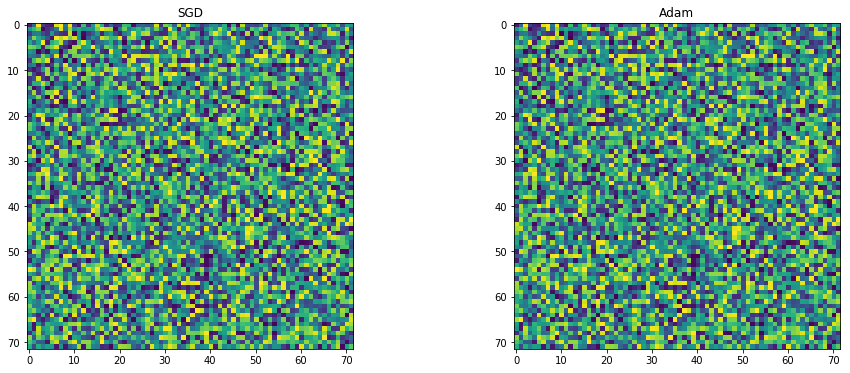

In [58]:
##### Visualisation of weights



fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SGD
column_img = model_final_sgd.get_weights()[0][:,99].reshape(72,72)
ax[0].imshow(column_img)
ax[0].set_title("SGD")

# Adam Optimizer
column_img = model_final_sgd.get_weights()[0][:,99].reshape(72,72)
ax[1].imshow(column_img)
ax[1].set_title("Adam")

#  A more difficult classfication problem

In [59]:
[X_train_new, Y_train_new] = generate_dataset_classification(300, 20, True)
target_train = to_categorical(Y_train_new)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


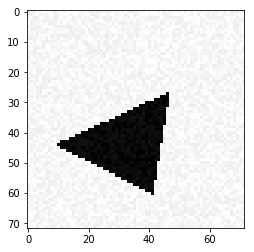

In [60]:
plt.imshow(X_train_new[3].reshape(72,72), cmap='gray')

#### Using Adam Optimizer

In [61]:
model_adam = Sequential()

model_adam.add(Dense(250, activation='relu', input_shape=(input_shape,)))
model_adam.add(Dense(250, activation='relu'))
model_adam.add(Dense(3, activation='softmax'))

model_adam.compile(optimizer='adam', 
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'],
                 )
    
model_adam.fit(X_train_new, 
              target_train, 
              validation_split=0.3,
              epochs = 500, 
              
            )

Train on 210 samples, validate on 90 samples
Epoch 1/500
210/210 [==============================] - 1s 5ms/step - loss: 2.4388 - acc: 0.3714 - val_loss: 1.4906 - val_acc: 0.4333
Epoch 2/500
210/210 [==============================] - 0s 1ms/step - loss: 2.2156 - acc: 0.3667 - val_loss: 1.4759 - val_acc: 0.2889
Epoch 3/500
210/210 [==============================] - 0s 860us/step - loss: 1.3116 - acc: 0.3619 - val_loss: 1.3735 - val_acc: 0.3000
Epoch 4/500
210/210 [==============================] - 0s 898us/step - loss: 1.0777 - acc: 0.4810 - val_loss: 0.9731 - val_acc: 0.5000
Epoch 5/500
210/210 [==============================] - 0s 898us/step - loss: 1.0404 - acc: 0.5095 - val_loss: 1.1680 - val_acc: 0.4889
Epoch 6/500
210/210 [==============================] - 0s 893us/step - loss: 0.9976 - acc: 0.5286 - val_loss: 1.0400 - val_acc: 0.5111
Epoch 7/500
210/210 [==============================] - 0s 917us/step - loss: 0.9211 - acc: 0.5476 - val_loss: 0.9122 - val_acc: 0.5222
Epoch 8/500
21

210/210 [==============================] - 0s 959us/step - loss: 0.5515 - acc: 0.7810 - val_loss: 1.2077 - val_acc: 0.4556
Epoch 62/500
210/210 [==============================] - 0s 902us/step - loss: 0.5721 - acc: 0.6905 - val_loss: 1.0097 - val_acc: 0.5556
Epoch 63/500
210/210 [==============================] - 0s 850us/step - loss: 0.5070 - acc: 0.7810 - val_loss: 1.0316 - val_acc: 0.5889
Epoch 64/500
210/210 [==============================] - 0s 898us/step - loss: 0.5370 - acc: 0.7524 - val_loss: 0.9746 - val_acc: 0.6111
Epoch 65/500
210/210 [==============================] - 0s 869us/step - loss: 0.5476 - acc: 0.7571 - val_loss: 0.9328 - val_acc: 0.6000
Epoch 66/500
210/210 [==============================] - 0s 945us/step - loss: 0.5650 - acc: 0.7762 - val_loss: 1.0901 - val_acc: 0.4778
Epoch 67/500
210/210 [==============================] - 0s 860us/step - loss: 0.4632 - acc: 0.8381 - val_loss: 1.2463 - val_acc: 0.4333
Epoch 68/500
210/210 [==============================] - 0s 86

210/210 [==============================] - 0s 912us/step - loss: 0.7468 - acc: 0.7429 - val_loss: 1.1279 - val_acc: 0.4000
Epoch 121/500
210/210 [==============================] - 0s 959us/step - loss: 0.5060 - acc: 0.7476 - val_loss: 1.3725 - val_acc: 0.4778
Epoch 122/500
210/210 [==============================] - 0s 926us/step - loss: 0.3775 - acc: 0.8571 - val_loss: 1.0038 - val_acc: 0.5667
Epoch 123/500
210/210 [==============================] - 0s 1ms/step - loss: 0.2882 - acc: 0.9095 - val_loss: 1.0471 - val_acc: 0.5667
Epoch 124/500
210/210 [==============================] - 0s 983us/step - loss: 0.4306 - acc: 0.8095 - val_loss: 1.1418 - val_acc: 0.6000
Epoch 125/500
210/210 [==============================] - 0s 1ms/step - loss: 0.4319 - acc: 0.8190 - val_loss: 1.2066 - val_acc: 0.5889
Epoch 126/500
210/210 [==============================] - 0s 974us/step - loss: 0.4646 - acc: 0.7571 - val_loss: 1.4599 - val_acc: 0.4556
Epoch 127/500
210/210 [==============================] - 0s

210/210 [==============================] - 0s 860us/step - loss: 0.1519 - acc: 0.9238 - val_loss: 1.4474 - val_acc: 0.5222
Epoch 181/500
210/210 [==============================] - 0s 807us/step - loss: 0.1715 - acc: 0.9190 - val_loss: 1.5333 - val_acc: 0.5778
Epoch 182/500
210/210 [==============================] - 0s 831us/step - loss: 0.3383 - acc: 0.8429 - val_loss: 1.3803 - val_acc: 0.5222
Epoch 183/500
210/210 [==============================] - 0s 907us/step - loss: 0.1676 - acc: 0.9333 - val_loss: 1.4703 - val_acc: 0.4667
Epoch 184/500
210/210 [==============================] - 0s 1ms/step - loss: 0.1115 - acc: 0.9857 - val_loss: 1.4358 - val_acc: 0.4889
Epoch 185/500
210/210 [==============================] - 0s 997us/step - loss: 0.1294 - acc: 0.9571 - val_loss: 2.2903 - val_acc: 0.4889
Epoch 186/500
210/210 [==============================] - 0s 945us/step - loss: 0.1935 - acc: 0.9143 - val_loss: 1.6018 - val_acc: 0.5333
Epoch 187/500
210/210 [==============================] - 

210/210 [==============================] - 0s 1ms/step - loss: 0.0384 - acc: 0.9952 - val_loss: 1.9574 - val_acc: 0.5333
Epoch 241/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0488 - acc: 0.9952 - val_loss: 2.2410 - val_acc: 0.4556
Epoch 242/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0426 - acc: 0.9905 - val_loss: 2.1460 - val_acc: 0.4667
Epoch 243/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0274 - acc: 1.0000 - val_loss: 2.0087 - val_acc: 0.5444
Epoch 244/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0519 - acc: 0.9905 - val_loss: 2.2048 - val_acc: 0.4667
Epoch 245/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0410 - acc: 0.9905 - val_loss: 2.3749 - val_acc: 0.4444
Epoch 246/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0377 - acc: 0.9952 - val_loss: 2.5187 - val_acc: 0.4556
Epoch 247/500
210/210 [==============================] - 0s 1ms/step 

Epoch 301/500
210/210 [==============================] - 0s 1ms/step - loss: 0.8641 - acc: 0.7429 - val_loss: 1.4465 - val_acc: 0.3778
Epoch 302/500
210/210 [==============================] - 0s 1ms/step - loss: 0.4462 - acc: 0.8381 - val_loss: 1.5435 - val_acc: 0.4556
Epoch 303/500
210/210 [==============================] - 0s 1ms/step - loss: 0.2829 - acc: 0.9143 - val_loss: 1.2718 - val_acc: 0.5222
Epoch 304/500
210/210 [==============================] - 0s 1ms/step - loss: 0.2545 - acc: 0.9238 - val_loss: 1.7493 - val_acc: 0.4222
Epoch 305/500
210/210 [==============================] - 0s 1ms/step - loss: 0.2213 - acc: 0.9381 - val_loss: 1.9358 - val_acc: 0.4222
Epoch 306/500
210/210 [==============================] - 0s 1ms/step - loss: 0.1828 - acc: 0.9619 - val_loss: 1.5057 - val_acc: 0.4667
Epoch 307/500
210/210 [==============================] - 0s 974us/step - loss: 0.1356 - acc: 0.9619 - val_loss: 1.6793 - val_acc: 0.4667
Epoch 308/500
210/210 [==============================

210/210 [==============================] - 0s 1ms/step - loss: 0.0384 - acc: 1.0000 - val_loss: 1.9102 - val_acc: 0.4667
Epoch 362/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0335 - acc: 1.0000 - val_loss: 1.9072 - val_acc: 0.4667
Epoch 363/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0247 - acc: 1.0000 - val_loss: 1.9808 - val_acc: 0.4556
Epoch 364/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0209 - acc: 1.0000 - val_loss: 2.0121 - val_acc: 0.4778
Epoch 365/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0184 - acc: 1.0000 - val_loss: 2.0753 - val_acc: 0.4667
Epoch 366/500
210/210 [==============================] - 0s 2ms/step - loss: 0.0145 - acc: 1.0000 - val_loss: 2.0875 - val_acc: 0.4889
Epoch 367/500
210/210 [==============================] - 0s 2ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 2.1588 - val_acc: 0.4667
Epoch 368/500
210/210 [==============================] - 0s 1ms/step 

Epoch 422/500
210/210 [==============================] - 1s 6ms/step - loss: 0.0204 - acc: 1.0000 - val_loss: 2.3081 - val_acc: 0.4667
Epoch 423/500
210/210 [==============================] - 1s 7ms/step - loss: 0.0235 - acc: 1.0000 - val_loss: 2.6662 - val_acc: 0.4889
Epoch 424/500
210/210 [==============================] - 2s 7ms/step - loss: 0.0367 - acc: 1.0000 - val_loss: 2.4189 - val_acc: 0.4667
Epoch 425/500
210/210 [==============================] - 1s 4ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 2.3581 - val_acc: 0.4556
Epoch 426/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0164 - acc: 1.0000 - val_loss: 2.3255 - val_acc: 0.4444
Epoch 427/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0249 - acc: 0.9952 - val_loss: 2.3256 - val_acc: 0.4556
Epoch 428/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0195 - acc: 1.0000 - val_loss: 2.4539 - val_acc: 0.4667
Epoch 429/500
210/210 [==============================] 

210/210 [==============================] - 0s 2ms/step - loss: 0.0269 - acc: 1.0000 - val_loss: 2.0347 - val_acc: 0.4889
Epoch 483/500
210/210 [==============================] - 0s 1ms/step - loss: 0.0290 - acc: 1.0000 - val_loss: 2.1637 - val_acc: 0.4889
Epoch 484/500
210/210 [==============================] - 0s 2ms/step - loss: 0.0231 - acc: 1.0000 - val_loss: 2.0622 - val_acc: 0.4889
Epoch 485/500
210/210 [==============================] - 0s 2ms/step - loss: 0.0194 - acc: 1.0000 - val_loss: 2.0701 - val_acc: 0.5000
Epoch 486/500
210/210 [==============================] - 1s 6ms/step - loss: 0.0195 - acc: 1.0000 - val_loss: 2.0644 - val_acc: 0.5111
Epoch 487/500
210/210 [==============================] - 1s 7ms/step - loss: 0.0170 - acc: 1.0000 - val_loss: 2.3565 - val_acc: 0.4667
Epoch 488/500
210/210 [==============================] - 2s 8ms/step - loss: 0.0164 - acc: 1.0000 - val_loss: 2.0511 - val_acc: 0.5222
Epoch 489/500
210/210 [==============================] - 1s 3ms/step 

In [62]:
[X_test_new, Y_test_new] = generate_test_set_classification()
model_adam.evaluate(X_test_new, Y_test_new)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 188us/step


[1.9206803766886393, 0.5733333325386047]

#### The performance of Sequential Adam Booster is poorer for this image. Furthermore  convergence is much slower.

### Adding Convolutional network with Adam booster

In [63]:
X_train_conv = X_train_new.reshape(X_train_new.shape[0], 72, 72,1)
X_test_conv = X_test_new.reshape(X_test_new.shape[0], 72, 72,1)

X_test_conv.shape

(300, 72, 72, 1)

In [64]:
model_conv = Sequential()
model_conv.add(Conv2D(16,(5,5), activation='relu', input_shape=(72,72,1)))
model_conv.add(MaxPooling2D(pool_size=(2,2)))
model_conv.add(Flatten())
model_conv.add(Dense(15, activation='relu'))
model_conv.add(Dense(15, activation='relu'))
model_conv.add(Dense(3, activation='softmax'))

model_conv.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_conv.fit(X_train_conv, target_train, epochs=100)

Epoch 1/100
300/300 [==============================] - 2s 6ms/step - loss: 1.1179 - acc: 0.3633
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 1.0596 - acc: 0.5267
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 1.0238 - acc: 0.4567
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.9616 - acc: 0.6000
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.8984 - acc: 0.5700
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.8401 - acc: 0.6233
Epoch 7/100
300/300 [==============================] - 5s 16ms/step - loss: 0.7925 - acc: 0.6833
Epoch 8/100
300/300 [==============================] - 1s 5ms/step - loss: 0.7293 - acc: 0.7267
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: 0.7082 - acc: 0.7267
Epoch 10/100
300/300 [==============================] - 1s 3ms/step - loss: 0.6641 - acc: 0.7533
Epoch 11/100
300/300 [================

300/300 [==============================] - 1s 3ms/step - loss: 0.0077 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0075 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0074 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0072 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0070 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0069 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0068 - acc: 1.0000
Epoch 93/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0066 - acc: 1.0000
Epoch 94/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0066 - acc: 1.0000
Epoch 95/100
300/300 [=====================

In [65]:
target_test = to_categorical(Y_test_new)
model_conv.evaluate(X_test_conv, Y_test_new)




300/300 [==============================] - 1s 2ms/step


[1.838902676900228, 0.6600000007947286]

### The loss error is  smaller and the accuracy is greater. In addition the convergence is quicker. This method enables to have then better results.

### Regression problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


NameError: name 'patches' is not defined

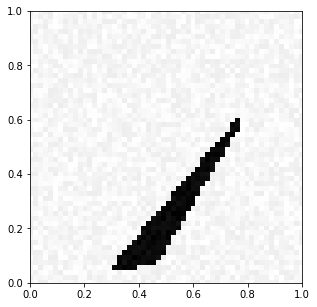

In [66]:
[X_train, Y_train] = generate_dataset_regression(300,20)
[X_test, Y_test] = generate_test_set_regression()

X_train_resh = X_train.reshape(X_train.shape[0],72, 72, 1)
X_test_resh = X_test.reshape(X_test.shape[0],72, 72, 1)



In [ ]:
## Reorder vertices

In [67]:



def reorder_coord_x_order(y_train):
    y_result = np.zeros(6)
    order_x = list(np.argsort(y_train[np.array([0,2,4])]))
    idx_to_fill = 0
    for i in order_x:
        idx_to_get = 2*i
        y_result[idx_to_fill] = y_train[idx_to_get]
        idx_to_fill += 1
        y_result[idx_to_fill] = y_train[idx_to_get+1]
        idx_to_fill += 1
    return y_result




In [68]:
Y_train_ord = np.apply_along_axis(reorder_coord_x_order, 1, Y_train)
Y_test_ord = np.apply_along_axis(reorder_coord_x_order, 1, Y_test)

In [69]:
model_reg = Sequential()
model_reg.add(Conv2D(32,(5,5), input_shape=(X_train_resh.shape[1],X_train_resh.shape[1],1)))
model_reg.add(MaxPooling2D(10))
model_reg.add(Dropout(0.25))
model_reg.add(Flatten())
model_reg.add(Dense(128, activation='relu'))
#model_reg.add(Dense(15, activation='relu'))
model_reg.add(Dense(6, activation='linear'))

In [70]:
model_reg.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])



#target_train = to_categorical(Y_train_ord)

model_reg.fit(X_train_resh, 
              Y_train_ord,
              batch_size=32,
              validation_split=0.3,
              epochs=200,
              verbose=2
             )


#

Train on 210 samples, validate on 90 samples
Epoch 1/200
 - 1s - loss: 0.1419 - mean_squared_error: 0.1419 - val_loss: 0.0678 - val_mean_squared_error: 0.0678
Epoch 2/200
 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 3/200
 - 1s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 4/200
 - 1s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0337 - val_mean_squared_error: 0.0337
Epoch 5/200
 - 1s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 6/200
 - 1s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 7/200
 - 1s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 8/200
 - 1s - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 9/200
 - 1s - loss: 0.0263 - mean_squ

Epoch 72/200
 - 1s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 73/200
 - 1s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 74/200
 - 1s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 75/200
 - 1s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 76/200
 - 1s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 77/200
 - 1s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 78/200
 - 1s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 79/200
 - 1s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 80/200
 - 1s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.020

Epoch 143/200
 - 1s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 144/200
 - 1s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 145/200
 - 1s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 146/200
 - 1s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 147/200
 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 148/200
 - 1s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 149/200
 - 1s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 150/200
 - 1s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 151/200
 - 1s - loss: 0.0022 - mean_squared_error: 0.0022 - val_lo

NameError: name 'patches' is not defined

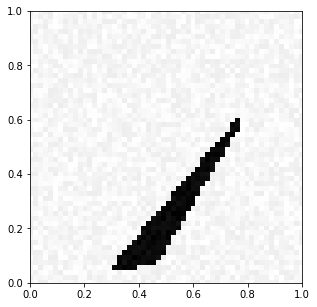

In [71]:
visualize_prediction(X_train[0], Y_train[0])